In [1]:
import torch
import torch.nn.functional as Fun

from torch.utils.data import TensorDataset, DataLoader
import torch.optim as optim

DTYPE = torch.float32

In [2]:
Fun.softmax(torch.tensor([1,2,3.]), dim=0)


tensor([0.0900, 0.2447, 0.6652])

In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [4]:
def in_jupyter():
	try:
		get_ipython
		return True
	except NameError:
		return False
if in_jupyter():
	from tqdm.notebook import trange
	from tqdm.notebook import tqdm
else:
	from tqdm import trange
	from tqdm import tqdm

# датасет: cпираль, и графики

In [5]:
def generate_dataset(dataset_type='spiral', n_samples=400, noise=1.3):
    """Генерация различных типов датасетов"""
    if dataset_type == 'circle':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
    elif dataset_type == 'xor':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1,
                                   flip_y=0.1, class_sep=0.5)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise)
    elif dataset_type == 'spiral':
        n = n_samples // 2
        theta = np.sqrt(np.random.rand(n)) * 4 * np.pi
        r_a = 2 * theta + np.pi
        data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
        x_a = data_a + np.random.normal(0,noise,(n,2))
        
        theta = np.sqrt(np.random.rand(n)) * 4 * np.pi
        r_b = -2 * theta - np.pi
        data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
        x_b = data_b + np.random.normal(0,noise,(n,2)) * noise
        
        X = np.vstack([x_a, x_b])
        y = np.hstack([np.zeros(n), np.ones(n)])
    else:  # linear
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1)
    
    #return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)
    return X, y.reshape(-1, 1)


In [6]:
np.random.normal(0,1.1,(5,2))

array([[-0.50203729, -1.55623548],
       [-1.71435431, -0.63914409],
       [ 0.34903008, -1.6264305 ],
       [-0.13887126, -1.93475049],
       [ 0.31731515,  1.99706322]])

In [7]:
X,y = generate_dataset(noise=1.3)

In [8]:
type(X)

numpy.ndarray

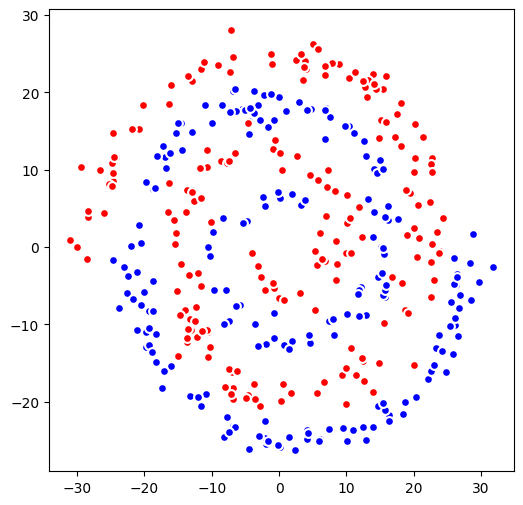

In [9]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 6))

def draw_dots(X,y,ax):
	#X_np, y_np = X.numpy(), y.numpy().flatten()
	X_np, y_np = X, y.flatten()
	ax.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], 
			   c='blue', s=40, edgecolors='white', linewidths=1.5, label='Class 0')
	ax.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], 
			   c='red', s=40, edgecolors='white', linewidths=1.5, label='Class 1')

draw_dots(X,y,ax)
#ax.set_xlim(x_min, x_max)
#ax.set_ylim(y_min, y_max)
plt.show()

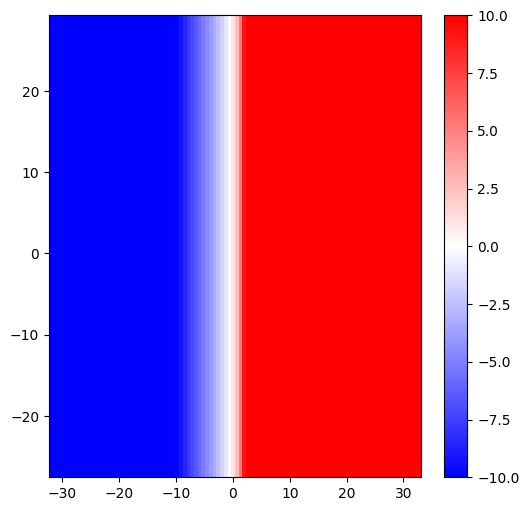

In [10]:
def foo(grid, draw=False):
	return np.exp(grid[:,0])+grid[:,0]

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

def as_numpy(model,X, *args, **kvargs):
	if isinstance(model,torch.nn.Module):
		with torch.no_grad():
			mp = next(model.parameters())
			return model(torch.tensor(X, dtype=mp.dtype, device=mp.device), *args, **kvargs, draw=True).detach().cpu().numpy()
	else:
		return model(X)
		
def calc_mesh(x_min, y_min, x_max, y_max, resolution = 100):
	xx, yy = np.meshgrid(
		np.linspace(x_min, x_max, resolution),
		np.linspace(y_min, y_max, resolution)
	)

	return xx, yy, np.c_[xx.ravel(), yy.ravel()]

def draw_mesh(foo, ax, x_min, y_min, x_max, y_max, resolution = 100, cmin=-10, cmax=10):
	xx,yy,grid = calc_mesh(x_min, y_min, x_max, y_max, resolution = 100)
	Z = as_numpy(foo,grid)
	norm = mcolors.TwoSlopeNorm(vmin=cmin, vcenter=0, vmax=cmax)
	
	return ax.pcolormesh(xx, yy, Z.reshape(xx.shape), cmap='bwr', norm=norm)

fig, ax = plt.subplots(figsize=(6, 6))
tmp = draw_mesh(foo,ax,x_min, y_min, x_max, y_max)
plt.colorbar(tmp, ax=ax)

plt.show()

# модели

In [11]:
import torch.nn as nn

In [64]:
class FeedForward(torch.nn.Module):
	"""Простая нейронная сеть с настраиваемой архитектурой"""
	def __init__(self, input_size=2, hidden_layers=[4, 4], activation=None, dtype=DTYPE):
		if activation is None: activation = lambda x: x
		super(FeedForward, self).__init__()

		self.layers = nn.ModuleList()
		self.activations = []
		self.activation_type = activation

		prev_size = input_size

		# Скрытые слои
		for hidden_size in hidden_layers:
			self.layers.append(nn.Linear(prev_size, hidden_size, dtype=dtype))
			self.activations.append(activation)
			prev_size = hidden_size

		# Выходной слой
		self.layers.append(nn.Linear(prev_size, 1))
		self.activations.append(nn.Sigmoid())

		# Для хранения промежуточных значений во время отрисовки состояния
		self.layer_outputs = []
		self.can_draw = 0
		# 0 - no data
		# 1 - has data, no axes
		# 2 - has data, has_axes

	def forward(self, X, draw=False): # __DRAW_INTERFACE__
		if draw:
			self.layer_outputs = []
			self.x_min, self.x_max = X[:, 0].min().cpu() - 1, X[:, 0].max().cpu() + 1
			self.y_min, self.y_max = X[:, 1].min().cpu() - 1, X[:, 1].max().cpu() + 1
			self.xx, self.yy, self.grid = calc_mesh(
				self.x_min, self.y_min, self.x_max, self.y_max, resolution = 100)
			self.can_draw = max(self.can_draw,1)

		for i, (layer, activation) in enumerate(zip(self.layers, self.activations)):
			X = activation(layer(X))
			if draw:
				self.layer_outputs.append(X.detach().clone())

		return X

	# __DRAW_INTERFACE__
	def draw_grid_size(self):
		return max(x.out_features for x in self.layers), len(self.layers)-1

	def draw(self, fig, gs):
		assert self.can_draw >=1
		self.can_draw = 2
		self.axes = []
		self.plots = []
		for ln in range(len(self.layers)-1):
			l_axes = []
			l_plots = []
			for nn in range(self.layers[ln].out_features):
				ax = fig.add_subplot(gs[nn,ln])
				l_axes.append(ax)
				Z = self.layer_outputs[ln][:,nn].cpu()
				norm = mcolors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
				plot = ax.pcolormesh(self.xx, self.yy, Z.reshape(self.xx.shape), cmap='bwr', norm=norm)
				l_plots.append(plot)
			self.axes.append(l_axes)
			self.plots.append(l_plots)

	def redraw(self):
		assert self.can_draw >=2, self.can_draw
		for ln in range(len(self.layers)-1):
			for nn in range(self.layers[ln].out_features):
				Z = self.layer_outputs[ln][:,nn].cpu()
				self.plots[ln][nn].set_array(Z.reshape(xx.shape))

In [56]:
lin = nn.Linear(2, 3)
for x in lin.parameters():
	print(type(x),x)

<class 'torch.nn.parameter.Parameter'> Parameter containing:
tensor([[ 0.1524, -0.5884],
        [ 0.5642, -0.4118],
        [ 0.4514, -0.3657]], requires_grad=True)
<class 'torch.nn.parameter.Parameter'> Parameter containing:
tensor([0.3332, 0.3195, 0.5083], requires_grad=True)


In [57]:
def init_weights(m):
	print(type(m),m)

model = FeedForward(2, [20, 20, 20], nn.ReLU())
model.apply(init_weights)

<class 'torch.nn.modules.linear.Linear'> Linear(in_features=2, out_features=20, bias=True)
<class 'torch.nn.modules.linear.Linear'> Linear(in_features=20, out_features=20, bias=True)
<class 'torch.nn.modules.linear.Linear'> Linear(in_features=20, out_features=20, bias=True)
<class 'torch.nn.modules.linear.Linear'> Linear(in_features=20, out_features=1, bias=True)
<class 'torch.nn.modules.container.ModuleList'> ModuleList(
  (0): Linear(in_features=2, out_features=20, bias=True)
  (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
  (3): Linear(in_features=20, out_features=1, bias=True)
)
<class 'torch.nn.modules.activation.ReLU'> ReLU()
<class '__main__.FeedForward'> FeedForward(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation_type): ReLU()
)


FeedForward(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1-2): 2 x Linear(in_features=20, out_features=20, bias=True)
    (3): Linear(in_features=20, out_features=1, bias=True)
  )
  (activation_type): ReLU()
)

In [58]:
model.draw_grid_size()

(20, 3)

In [59]:
type(as_numpy(model,X))

numpy.ndarray

In [60]:
model.layers[0].weight.dtype

torch.float32

# учим онлайн

In [61]:
type(X)

numpy.ndarray

model.draw: 2


Output()

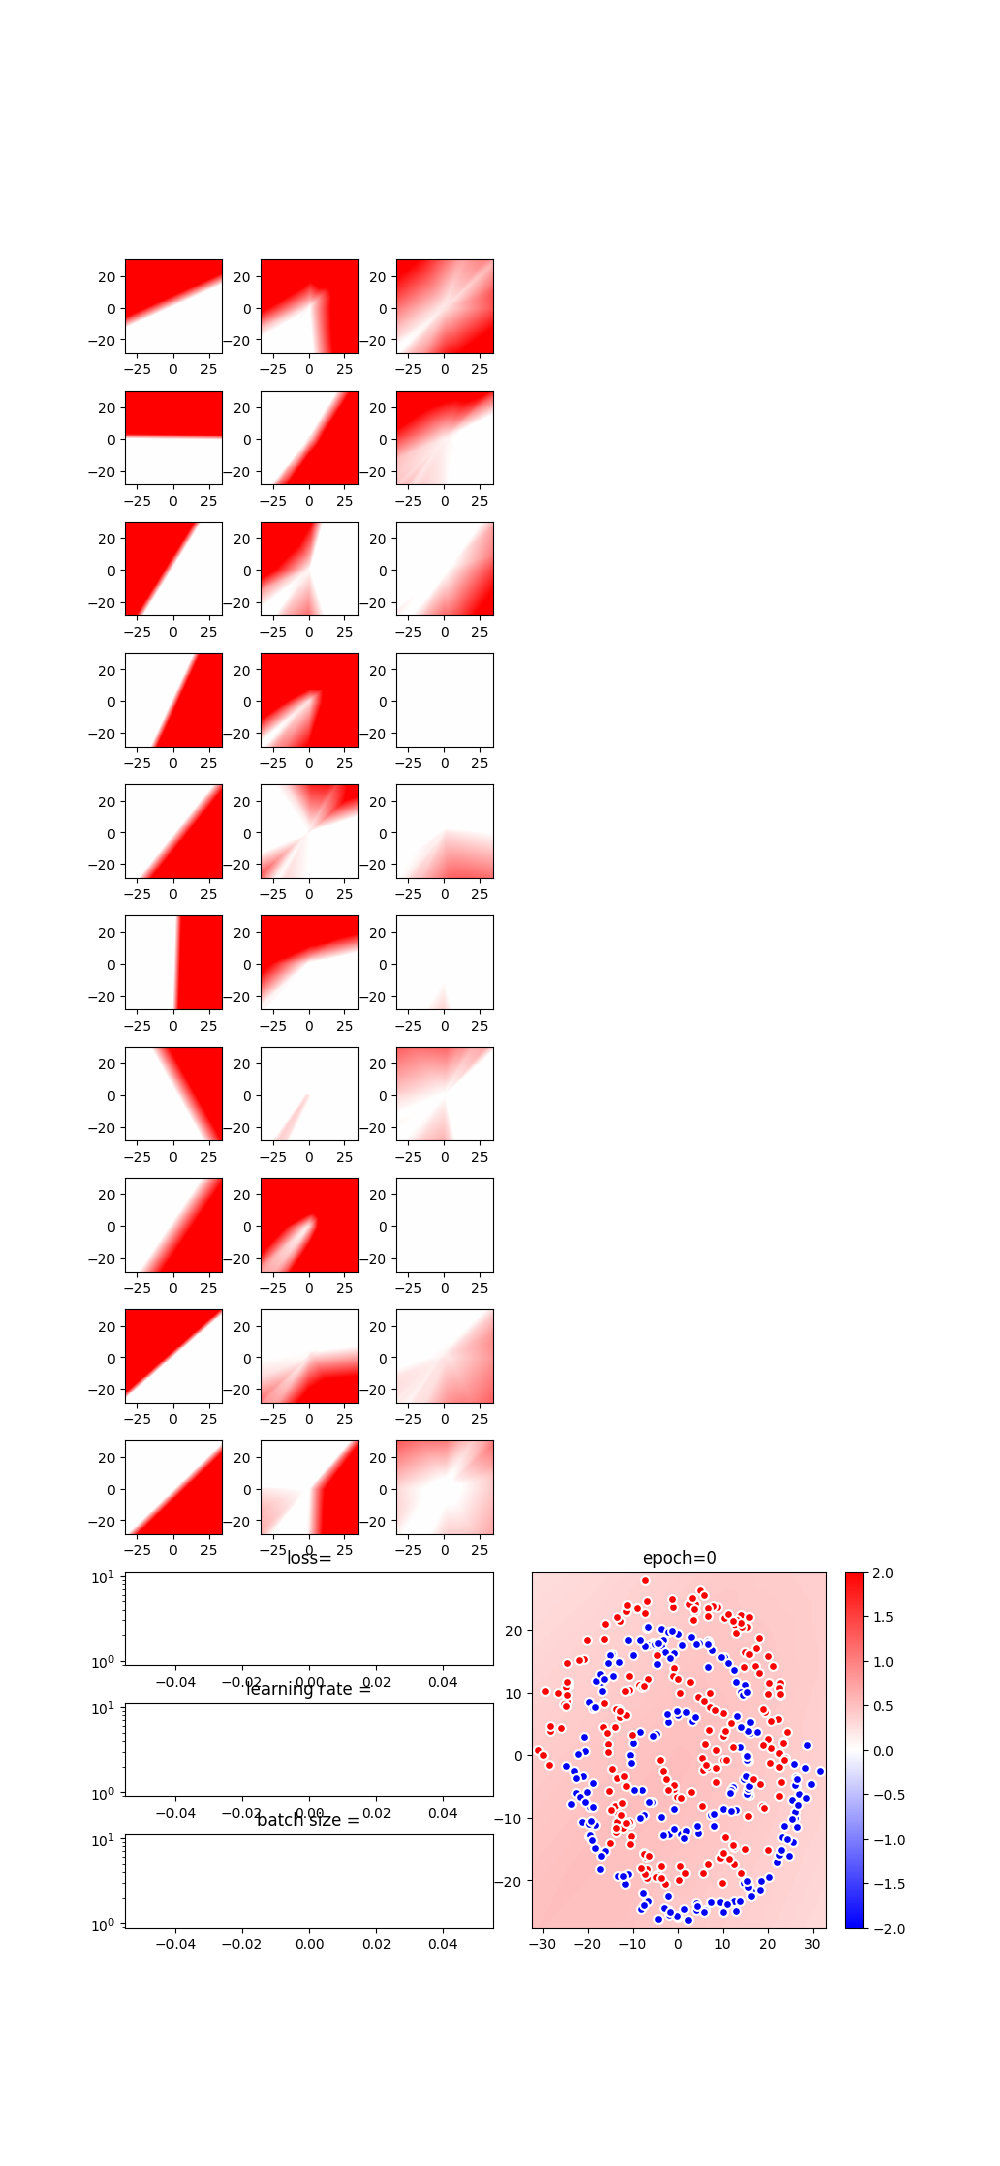

In [63]:
%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import ipywidgets as widgets
import threading
import sys
import time

# === model ===
model = FeedForward(2, [10, 10, 10], nn.ReLU())
# веса инициализируются по дефолту
criterion = nn.BCELoss()

# === обновление параметров ===
printput = widgets.Output()

learning_rate = 0.001
lr_changed = True
def update_learning_rate():
	global optimizer
	optimizer = optim.Adam(model.parameters(), lr=learning_rate)
	#optimizer = optim.SGD(model.parameters(), lr=learning_rate)
	global lr_changed
	lr_changed = False

device='cuda'
#device='cpu'
train_set = TensorDataset(torch.tensor(X, dtype=DTYPE).to(device), torch.tensor(y, dtype=DTYPE).to(device))
model.to(device)
batch_size = 16
bs_changed = True
def update_batch_size():
	global loader
	loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
	# suffle происходит при каждом вызове iter()/for
	global bs_changed
	bs_changed = False

loss_history = []
lr_history = []
bs_history = []

# === отрисовка ===
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

plot_h, plot_w = model.draw_grid_size()
plot_w = max(plot_w,6)
plot_h +=3
fig = plt.figure(figsize=(10,10/plot_w*plot_h))
gs = GridSpec(plot_h,plot_w,figure=fig, hspace=0.4, wspace=0.4)
#fig, ax_main = plt.subplots(figsize=(8, 8))

ax_main = fig.add_subplot(gs[-3:,-3:])
pl_main = draw_mesh(model,ax_main,x_min, y_min, x_max, y_max, cmin=-2, cmax=2)
plt.colorbar(pl_main, ax=ax_main)
ttl_main = ax_main.set_title('0')
draw_dots(X,y,ax_main)

model.draw(fig,gs)

ax_loss = fig.add_subplot(gs[-3,:-3])
pl_loss, = ax_loss.plot(loss_history)
ax_loss.set_yscale("log")
ttl_loss = ax_loss.set_title('loss')

ax_lr = fig.add_subplot(gs[-2,:-3])
pl_lr, = ax_lr.plot(lr_history)
ax_lr.set_yscale("log")
ttl_lr = ax_lr.set_title('learning rate')

ax_bs = fig.add_subplot(gs[-1,:-3])
pl_bs, = ax_bs.plot(bs_history)
ax_bs.set_yscale("log")
ttl_bs = ax_bs.set_title('batch size')

xx,yy,grid = calc_mesh(x_min, y_min, x_max, y_max, resolution = 100)
def redraw():
	pl_main.set_array(as_numpy(model, grid).reshape(xx.shape))
	ttl_main.set_text(f"epoch={len(loss_history)}")

	model.redraw()

	pl_loss.set_data(list(range(len(loss_history))), loss_history)
	ax_loss.relim()
	ax_loss.autoscale_view()
	ttl_loss.set_text(f"loss={loss_history[-1] if len(loss_history)>0 else '':.4}")

	pl_lr.set_data(list(range(len(lr_history))), lr_history)
	ax_lr.relim()
	ax_lr.autoscale_view()
	ttl_lr.set_text(f"learning rate ={lr_history[-1] if len(lr_history)>0 else '':.4}")

	pl_bs.set_data(list(range(len(bs_history))), bs_history)
	ax_bs.relim()
	ax_bs.autoscale_view()
	ttl_bs.set_text(f"batch size ={bs_history[-1] if len(bs_history)>0 else ''}")

	fig.canvas.draw_idle()

update_learning_rate()
update_batch_size()
redraw()

# === обучение ===
running = False
def learn():
	global loss_history
	t0 = time.time()
	while running:
		if lr_changed: update_learning_rate()
		if bs_changed: update_batch_size()
		mean_loss = 0
		n_batch = 0
		for X,y in loader:
			loss = criterion(model(X), y)

			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			mean_loss += loss.item()
			n_batch +=1

		loss_history.append(mean_loss/n_batch)
		lr_history.append(optimizer.param_groups[0]['lr'])
		bs_history.append(loader.batch_size)

		if time.time() - t0 > 0.03:
			t0 = time.time()
			redraw()
	redraw()

# === управление ===
start_stop = widgets.ToggleButton(value=False, description='Старт', icon='play')
@printput.capture(clear_output=False)
def on_toggle(change):
	global running
	if change['new']:
		start_stop.description = 'Стоп'
		start_stop.icon = 'pause'
		running = True
		threading.Thread(target=learn, daemon=True).start()
	else:
		start_stop.description = 'Старт'
		start_stop.icon = 'play'
		running = False
start_stop.observe(on_toggle, names='value')

def f(k): return [10*k,22*k,47*k]
lr_slider = widgets.SelectionSlider(
	options=f(1e-6)+f(1e-5)+f(1e-4)+f(1e-3)+f(1e-2)+f(1e-1)+f(1e0)+f(1e1),
	value=learning_rate,
	description='Learning Rate',
	continuous_update=True
)
@printput.capture(clear_output=False)
def lr_change(change):
	global learning_rate, lr_changed
	learning_rate = change['new']
	lr_changed = True
lr_slider.observe(lr_change, names='value')

bs_slider = widgets.SelectionSlider(
	options=[1,2,4,8,16,32,64,128,256],
	value=batch_size,
	description='Batch size',
	continuous_update=True
)
@printput.capture(clear_output=False)
def bs_change(change):
	global batch_size, bs_changed
	batch_size = change['new']
	bs_changed = True
bs_slider.observe(bs_change, names='value')

display(widgets.HBox([start_stop,lr_slider,bs_slider]),printput)
plt.show()


In [ ]:
model.to('cuda')

реализовать NNplayground на torch  
	`foo(число_эпох)` и в конце картинки для каждого нейрона  
	`foo(inf)` обновлять картинки 1р/сек, по прерыванию останавливаться после эпохи  

In [11]:
"""
Neural Network Playground - PyTorch Implementation
Интерактивная визуализация обучения нейронной сети
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display
import ipywidgets as widgets
from sklearn.datasets import make_classification, make_circles, make_moons

# Установка случайного seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

In [ ]:
class NeuralNetwork(nn.Module):
    """Простая нейронная сеть с настраиваемой архитектурой"""
    def __init__(self, input_size=2, hidden_layers=[4, 4], activation='tanh'):
        super(NeuralNetwork, self).__init__()
        
        layers = []
        prev_size = input_size
        
        # Скрытые слои
        for hidden_size in hidden_layers:
            layers.append(nn.Linear(prev_size, hidden_size))
            if activation == 'tanh':
                layers.append(nn.Tanh())
            elif activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'sigmoid':
                layers.append(nn.Sigmoid())
            prev_size = hidden_size
        
        # Выходной слой
        layers.append(nn.Linear(prev_size, 1))
        layers.append(nn.Sigmoid())
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

def generate_dataset(dataset_type='circle', n_samples=400, noise=1):
    """Генерация различных типов датасетов"""
    if dataset_type == 'circle':
        X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
    elif dataset_type == 'xor':
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1,
                                   flip_y=0.1, class_sep=0.5)
    elif dataset_type == 'moons':
        X, y = make_moons(n_samples=n_samples, noise=noise)
    elif dataset_type == 'spiral':
        n = n_samples // 2
        theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
        r_a = 2 * theta + np.pi
        data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
        x_a = data_a + np.random.randn(n, 2) * noise
        
        theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
        r_b = -2 * theta - np.pi
        data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
        x_b = data_b + np.random.randn(n, 2) * noise
        
        X = np.vstack([x_a, x_b])
        y = np.hstack([np.zeros(n), np.ones(n)])
    else:  # linear
        X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
                                   n_informative=2, n_clusters_per_class=1)
    
    return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)

def plot_decision_boundary(model, X, y, ax, resolution=100):
    """Визуализация границы решения"""
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
                         np.linspace(y_min, y_max, resolution))
    
    grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
    
    with torch.no_grad():
        Z = model(grid).numpy().reshape(xx.shape)
    
    ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.6)
    ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
    
    # Отображение точек данных
    X_np, y_np = X.numpy(), y.numpy().flatten()
    ax.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], 
               c='blue', s=50, edgecolors='k', label='Class 0')
    ax.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], 
               c='red', s=50, edgecolors='k', label='Class 1')
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend()

def train_network(dataset_type='circle', hidden_layers=[4, 4], 
                 activation='tanh', learning_rate=0.01, 
                 epochs=1000, plot_every=50):
    """Обучение нейронной сети с визуализацией"""
    
    # Генерация данных
    X, y = generate_dataset(dataset_type)
    
    # Создание модели
    model = NeuralNetwork(input_size=2, hidden_layers=hidden_layers, 
                         activation=activation)
    
    # Функция потерь и оптимизатор
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # История обучения
    loss_history = []
    accuracy_history = []
    
    # Настройка графиков
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    print(f"Обучение начато...")
    print(f"Dataset: {dataset_type}, Hidden layers: {hidden_layers}, "
          f"Activation: {activation}, LR: {learning_rate}")
    print("-" * 60)
    
    for epoch in range(epochs):
        # Прямой проход
        outputs = model(X)
        loss = criterion(outputs, y)
        
        # Обратное распространение
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Расчет точности
        predicted = (outputs > 0.5).float()
        accuracy = (predicted == y).float().mean()
        
        loss_history.append(loss.item())
        accuracy_history.append(accuracy.item())
        
        # Визуализация
        if (epoch + 1) % plot_every == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} - Loss: {loss.item():.4f}, "
                  f"Accuracy: {accuracy.item():.4f}")
            
            # Очистка графиков
            ax1.clear()
            ax2.clear()
            ax3.clear()
            
            # График границы решения
            plot_decision_boundary(model, X, y, ax1)
            ax1.set_title(f'Decision Boundary (Epoch {epoch+1})')
            ax1.set_xlabel('Feature 1')
            ax1.set_ylabel('Feature 2')
            
            # График потерь
            ax2.plot(loss_history, color='blue')
            ax2.set_title('Training Loss')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Loss')
            ax2.grid(True)
            
            # График точности
            ax3.plot(accuracy_history, color='green')
            ax3.set_title('Training Accuracy')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('Accuracy')
            ax3.grid(True)
            
            plt.tight_layout()
            display(fig)
            plt.pause(0.1)
            
            from IPython.display import clear_output
            if epoch < epochs - 1:
                clear_output(wait=True)
    
    print("\nОбучение завершено!")
    print(f"Финальная Loss: {loss_history[-1]:.4f}")
    print(f"Финальная Accuracy: {accuracy_history[-1]:.4f}")
    
    plt.show()
    
    return model, loss_history, accuracy_history

# Интерактивные виджеты для настройки параметров
def create_interactive_playground():
    """Создание интерактивного интерфейса"""
    
    dataset_widget = widgets.Dropdown(
        options=['circle', 'xor', 'moons', 'spiral', 'linear'],
        value='circle',
        description='Dataset:',
    )
    
    activation_widget = widgets.Dropdown(
        options=['tanh', 'relu', 'sigmoid'],
        value='tanh',
        description='Activation:',
    )
    
    lr_widget = widgets.FloatSlider(
        value=0.01,
        min=0.001,
        max=0.1,
        step=0.001,
        description='Learning Rate:',
    )
    
    epochs_widget = widgets.IntSlider(
        value=500,
        min=100,
        max=2000,
        step=100,
        description='Epochs:',
    )
    
    hidden1_widget = widgets.IntSlider(
        value=4,
        min=2,
        max=16,
        step=2,
        description='Hidden Layer 1:',
    )
    
    hidden2_widget = widgets.IntSlider(
        value=4,
        min=2,
        max=16,
        step=2,
        description='Hidden Layer 2:',
    )
    
    button = widgets.Button(description="Train Network")
    output = widgets.Output()
    
    def on_button_click(b):
        with output:
            clear_output()
            hidden_layers = [hidden1_widget.value, hidden2_widget.value]
            train_network(
                dataset_type=dataset_widget.value,
                hidden_layers=hidden_layers,
                activation=activation_widget.value,
                learning_rate=lr_widget.value,
                epochs=epochs_widget.value
            )
    
    button.on_click(on_button_click)
    
    display(widgets.VBox([
        dataset_widget,
        activation_widget,
        lr_widget,
        epochs_widget,
        hidden1_widget,
        hidden2_widget,
        button,
        output
    ]))

# Пример использования без интерактивных виджетов
print("=" * 60)
print("Neural Network Playground - PyTorch")
print("=" * 60)
print("\nДоступные функции:")
print("1. train_network() - обучение с параметрами по умолчанию")
print("2. create_interactive_playground() - интерактивный интерфейс (требует ipywidgets)")
print("\nПример использования:")
print("model, loss, acc = train_network(dataset_type='circle', hidden_layers=[8, 4], activation='tanh', learning_rate=0.01, epochs=500)")
print("\n" + "=" * 60)

Neural Network Playground - PyTorch

Доступные функции:
1. train_network() - обучение с параметрами по умолчанию
2. create_interactive_playground() - интерактивный интерфейс (требует ipywidgets)

Пример использования:
model, loss, acc = train_network(dataset_type='circle', hidden_layers=[8, 4], activation='tanh', learning_rate=0.01, epochs=500)



Epoch 500/500 - Loss: 0.0544, Accuracy: 0.9850


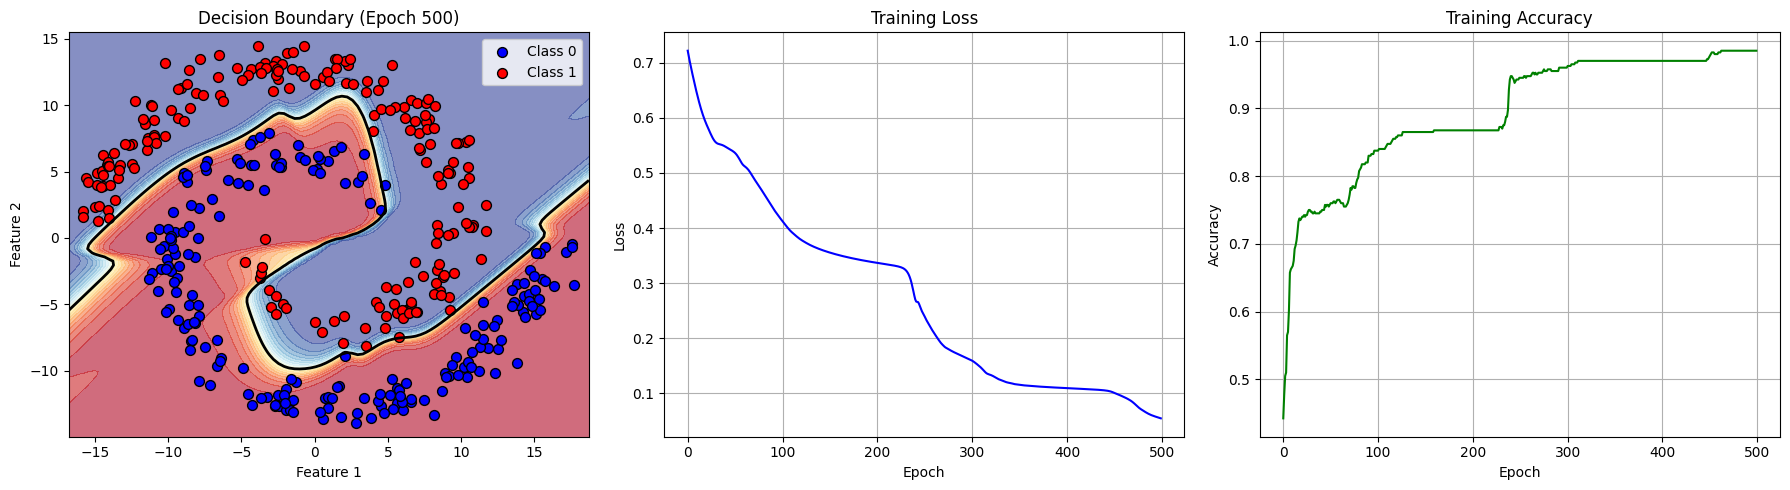

<Figure size 640x480 with 0 Axes>


Обучение завершено!
Финальная Loss: 0.0544
Финальная Accuracy: 0.9850


(NeuralNetwork(
   (network): Sequential(
     (0): Linear(in_features=2, out_features=8, bias=True)
     (1): Tanh()
     (2): Linear(in_features=8, out_features=4, bias=True)
     (3): Tanh()
     (4): Linear(in_features=4, out_features=1, bias=True)
     (5): Sigmoid()
   )
 ),
 [0.7220706939697266,
  0.7127758860588074,
  0.7039320468902588,
  0.6954998970031738,
  0.6873559355735779,
  0.6794183850288391,
  0.6716309189796448,
  0.6639726161956787,
  0.656462550163269,
  0.6491401791572571,
  0.6420478224754333,
  0.6352182030677795,
  0.6286709904670715,
  0.6224156022071838,
  0.616460382938385,
  0.6108189225196838,
  0.6055083274841309,
  0.6005375385284424,
  0.5958935618400574,
  0.5915341973304749,
  0.5873924493789673,
  0.5833925604820251,
  0.5794730186462402,
  0.5756064057350159,
  0.5718117952346802,
  0.5681519508361816,
  0.5647205114364624,
  0.5616212487220764,
  0.5589474439620972,
  0.5567628741264343,
  0.5550863146781921,
  0.553880512714386,
  0.5530551075935

In [10]:
# Запуск обучения с параметрами по умолчанию
train_network(dataset_type='spiral', hidden_layers=[8, 4], 
             activation='tanh', learning_rate=0.01, epochs=500, plot_every=50)

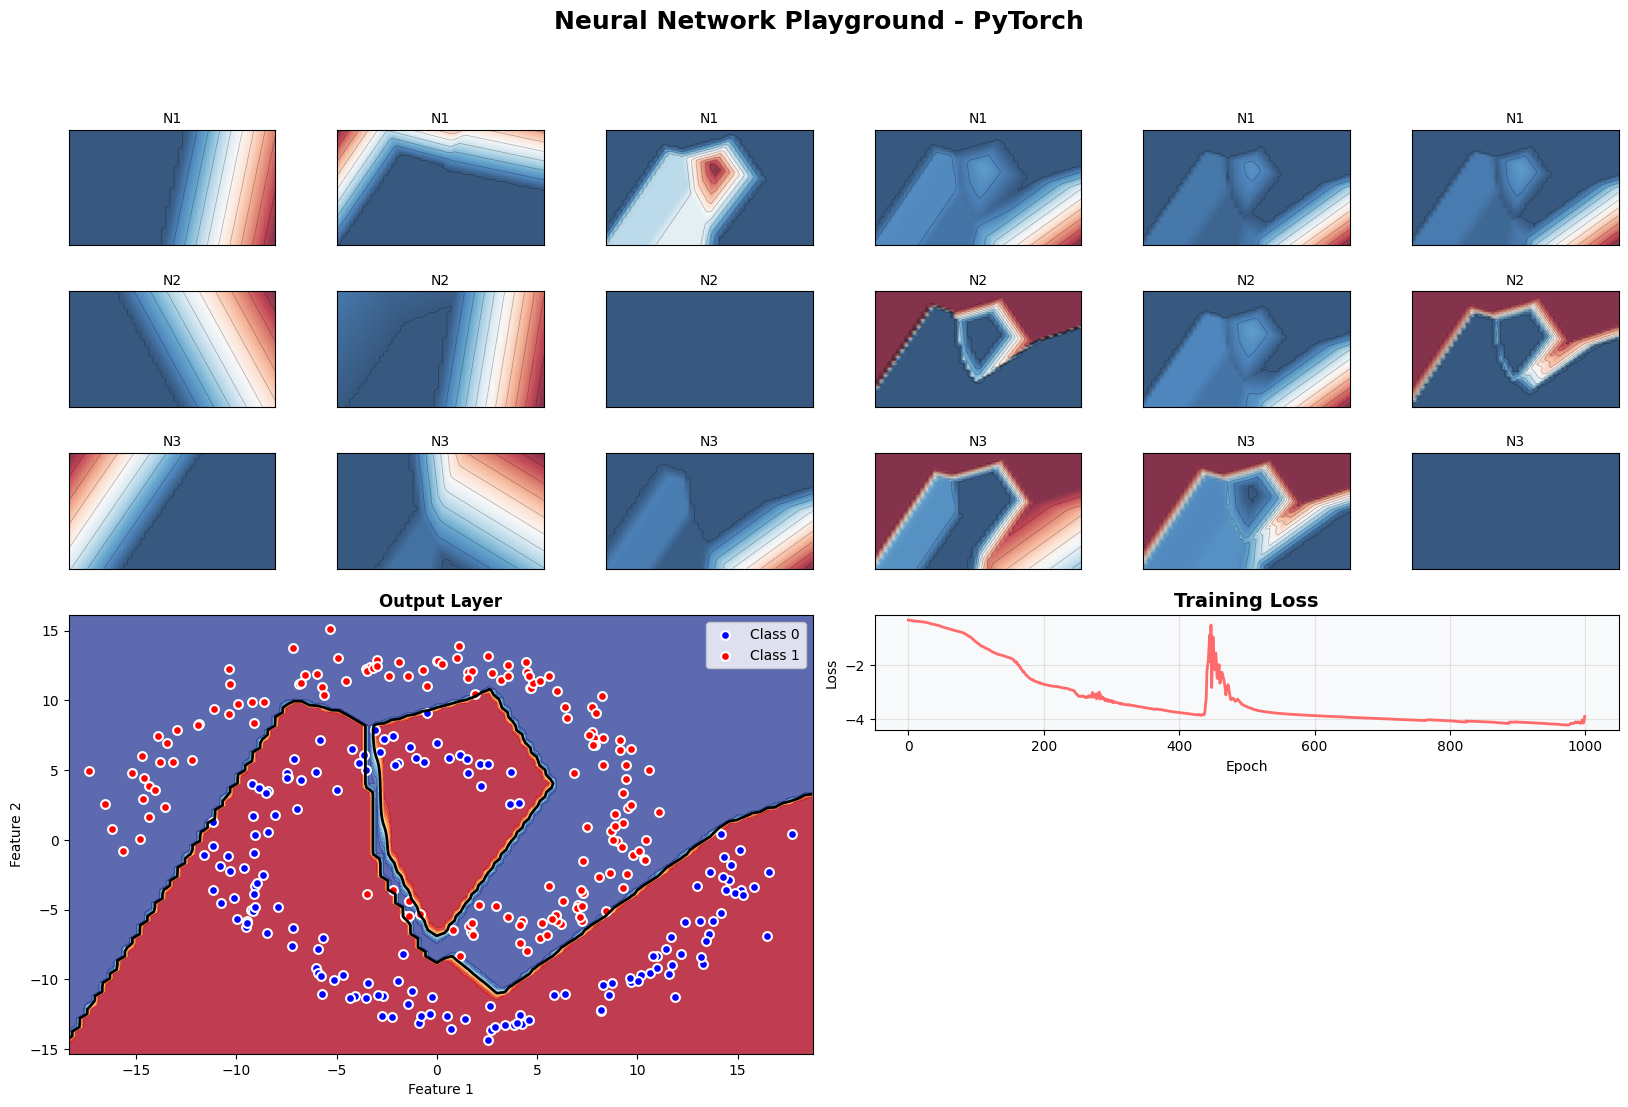

In [4]:
"""
Neural Network Playground - PyTorch Implementation
Интерактивная визуализация обучения нейронной сети с визуализацией активаций нейронов
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display, clear_output
import ipywidgets as widgets
from sklearn.datasets import make_classification, make_circles, make_moons

# Установка случайного seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

class NeuralNetwork(nn.Module):
	"""Простая нейронная сеть с настраиваемой архитектурой"""
	def __init__(self, input_size=2, hidden_layers=[4, 4], activation='tanh'):
		super(NeuralNetwork, self).__init__()
		
		self.layers = nn.ModuleList()
		self.activations = []
		self.activation_type = activation
		
		prev_size = input_size
		
		# Скрытые слои
		for hidden_size in hidden_layers:
			self.layers.append(nn.Linear(prev_size, hidden_size))
			if activation == 'tanh':
				self.activations.append(nn.Tanh())
			elif activation == 'relu':
				self.activations.append(nn.ReLU())
			elif activation == 'sigmoid':
				self.activations.append(nn.Sigmoid())
			prev_size = hidden_size
		
		# Выходной слой
		self.layers.append(nn.Linear(prev_size, 1))
		self.output_activation = nn.Sigmoid()
		
		# Для хранения активаций
		self.layer_outputs = []
	
	def forward(self, x):
		self.layer_outputs = []
		
		for i, (layer, activation) in enumerate(zip(self.layers[:-1], self.activations)):
			x = layer(x)
			x = activation(x)
			self.layer_outputs.append(x.detach().clone())
		
		# Выходной слой
		x = self.layers[-1](x)
		x = self.output_activation(x)
		self.layer_outputs.append(x.detach().clone())
		
		return x

def generate_dataset(dataset_type='circle', n_samples=300, noise=1):
	"""Генерация различных типов датасетов"""
	if dataset_type == 'circle':
		X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
	elif dataset_type == 'xor':
		X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
								   n_informative=2, n_clusters_per_class=1,
								   flip_y=0.1, class_sep=0.5)
	elif dataset_type == 'moons':
		X, y = make_moons(n_samples=n_samples, noise=noise)
	elif dataset_type == 'spiral':
		n = n_samples // 2
		theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
		r_a = 2 * theta + np.pi
		data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
		x_a = data_a + np.random.randn(n, 2) * noise
		
		theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
		r_b = -2 * theta - np.pi
		data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
		x_b = data_b + np.random.randn(n, 2) * noise
		
		X = np.vstack([x_a, x_b])
		y = np.hstack([np.zeros(n), np.ones(n)])
	else:  # linear
		X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
								   n_informative=2, n_clusters_per_class=1)
	
	return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)

def plot_neuron_activation(model, X, neuron_idx, layer_idx, ax, resolution=50):
	"""Визуализация активации конкретного нейрона"""
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	
	xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
						 np.linspace(y_min, y_max, resolution))
	
	grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
	
	with torch.no_grad():
		_ = model(grid)
		activations = model.layer_outputs[layer_idx]
		Z = activations[:, neuron_idx].numpy().reshape(xx.shape)
	
	# Отображение активации нейрона
	im = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], 
				   origin='lower', cmap='RdBu_r', alpha=0.8, aspect='auto')
	ax.contour(xx, yy, Z, levels=10, colors='black', linewidths=0.5, alpha=0.3)
	
	ax.set_xlim(x_min, x_max)
	ax.set_ylim(y_min, y_max)
	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_title(f'N{neuron_idx+1}', fontsize=10, pad=5)
	
	return im

def plot_decision_boundary(model, X, y, ax, resolution=100):
	"""Визуализация границы решения"""
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	
	xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
						 np.linspace(y_min, y_max, resolution))
	
	grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
	
	with torch.no_grad():
		Z = model(grid).numpy().reshape(xx.shape)
	
	ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.8)
	ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
	
	# Отображение точек данных
	X_np, y_np = X.numpy(), y.numpy().flatten()
	ax.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], 
			   c='blue', s=40, edgecolors='white', linewidths=1.5, label='Class 0')
	ax.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], 
			   c='red', s=40, edgecolors='white', linewidths=1.5, label='Class 1')
	
	ax.set_xlim(x_min, x_max)
	ax.set_ylim(y_min, y_max)
	ax.set_xlabel('Feature 1')
	ax.set_ylabel('Feature 2')
	ax.legend(loc='upper right')
	ax.set_title('Output Layer', fontweight='bold')

def visualize_network(model, X, y, loss_history, accuracy_history):
	"""Визуализация всей сети с активациями нейронов"""
	
	# Подсчет количества нейронов в каждом слое
	hidden_layers = [layer.out_features for layer in model.layers[:-1]]
	num_layers = len(hidden_layers)
	max_neurons = max(hidden_layers) if hidden_layers else 0
	
	# Создание сетки для графиков
	fig = plt.figure(figsize=(20, 12))
	gs = GridSpec(max_neurons + 3, max(num_layers,5), figure=fig, hspace=0.4, wspace=0.3)
	
	# Получаем активации для всех нейронов
	with torch.no_grad():
		_ = model(X)
	
	# Визуализация скрытых слоев
	for layer_idx, num_neurons in enumerate(hidden_layers):
		for neuron_idx in range(num_neurons):
			ax = fig.add_subplot(gs[neuron_idx, layer_idx])
			plot_neuron_activation(model, X, neuron_idx, layer_idx, ax)
		
		# Заголовок слоя
		ax_title = fig.add_subplot(gs[max_neurons, layer_idx])
		ax_title.text(0.5, 0.5, f'Hidden Layer {layer_idx + 1}\n({num_neurons} neurons)', 
					  ha='center', va='center', fontsize=12, fontweight='bold')
		ax_title.axis('off')
	
	# Визуализация выходного слоя
	ax_output = fig.add_subplot(gs[max_neurons:, 0:3])
	plot_decision_boundary(model, X, y, ax_output)
	
	# График потерь
	ax_loss = fig.add_subplot(gs[max_neurons, 3:])
	ax_loss.plot(np.log(np.array(loss_history)), color='#FF6B6B', linewidth=2)
	ax_loss.set_title('Training Loss', fontweight='bold', fontsize=14)
	ax_loss.set_xlabel('Epoch')
	ax_loss.set_ylabel('Loss')
	ax_loss.grid(True, alpha=0.3)
	ax_loss.set_facecolor('#F8F9FA')
	
	# График точности
#	ax_acc = fig.add_subplot(gs[max_neurons+1:, 3:])
#	ax_acc.plot(accuracy_history, color='#51CF66', linewidth=2)
#	ax_acc.set_title('Training Accuracy', fontweight='bold', fontsize=14)
#	ax_acc.set_xlabel('Epoch')
#	ax_acc.set_ylabel('Accuracy')
#	ax_acc.grid(True, alpha=0.3)
#	ax_acc.set_facecolor('#F8F9FA')
	
	# Информация о модели
#	ax_info = fig.add_subplot(gs[max_neurons:, num_layers+1:])
#	info_text = f"Architecture: {[2] + hidden_layers + [1]}\n"
#	info_text += f"Activation: {model.activation_type}\n"
#	info_text += f"Final Loss: {loss_history[-1]:.4f}\n"
#	info_text += f"Final Accuracy: {accuracy_history[-1]:.4f}\n"
#	info_text += f"Total Parameters: {sum(p.numel() for p in model.parameters())}"
#	ax_info.text(0.1, 0.5, info_text, ha='left', va='center', 
#				 fontsize=11, family='monospace',
#				 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
#	ax_info.axis('off')
	
	plt.suptitle('Neural Network Playground - PyTorch', 
				 fontsize=18, fontweight='bold', y=0.98)
	
	return fig

def train_network(dataset_type='circle', hidden_layers=[4, 4], 
				 activation='tanh', learning_rate=0.01, 
				 epochs=1000, plot_every=50):
	global model
	global loss_history
	global accuracy_history

	"""Обучение нейронной сети с визуализацией"""
	
	# Генерация данных
	X, y = generate_dataset(dataset_type)
	
	# Создание модели
	model = NeuralNetwork(input_size=2, hidden_layers=hidden_layers, 
						 activation=activation)
	
	# Функция потерь и оптимизатор
	criterion = nn.BCELoss()
	optimizer = optim.Adam(model.parameters(), lr=learning_rate)
	
	# История обучения
	loss_history = []
	accuracy_history = []
	
	print(f"🚀 Обучение начато...")
	print(f"📊 Dataset: {dataset_type}")
	print(f"🧠 Architecture: {[2] + hidden_layers + [1]}")
	print(f"⚡ Activation: {activation}")
	print(f"📈 Learning Rate: {learning_rate}")
	print("-" * 70)
	
	for epoch in range(epochs):
		# Прямой проход
		outputs = model(X)
		loss = criterion(outputs, y)
		
		# Обратное распространение
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Расчет точности
		predicted = (outputs > 0.5).float()
		accuracy = (predicted == y).float().mean()
		
		loss_history.append(loss.item())
		accuracy_history.append(accuracy.item())
		
		# Визуализация
		if (epoch + 1) % plot_every == 0 or epoch == 0:
			print(f"Epoch {epoch+1:4d}/{epochs} - Loss: {loss.item():.4f}, "
				  f"Accuracy: {accuracy.item():.4f}")
			
			clear_output(wait=True)
			
			fig = visualize_network(model, X, y, loss_history, accuracy_history)
			plt.show()
			
			print(f"\n🎯 Epoch {epoch+1}/{epochs}")
			print(f"📉 Loss: {loss.item():.4f}")
			print(f"🎯 Accuracy: {accuracy.item():.4f}")
			print("-" * 70)
	
	print("\n✅ Обучение завершено!")
	print(f"📉 Финальная Loss: {loss_history[-1]:.4f}")
	print(f"🎯 Финальная Accuracy: {accuracy_history[-1]:.4f}")
	
	# Финальная визуализация
	clear_output(wait=True)
	fig = visualize_network(model, X, y, loss_history, accuracy_history)
	plt.show()
	
# Интерактивные виджеты для настройки параметров
def create_interactive_playground():
	"""Создание интерактивного интерфейса"""
	
	dataset_widget = widgets.Dropdown(
		options=['circle', 'xor', 'moons', 'spiral', 'linear'],
		value='circle',
		description='Dataset:',
		style={'description_width': 'initial'}
	)
	
	activation_widget = widgets.Dropdown(
		options=['tanh', 'relu', 'sigmoid'],
		value='tanh',
		description='Activation:',
		style={'description_width': 'initial'}
	)
	
	lr_widget = widgets.FloatLogSlider(
		value=0.01,
		base=10,
		min=-4,
		max=-1,
		step=0.1,
		description='Learning Rate:',
		style={'description_width': 'initial'}
	)
	
	epochs_widget = widgets.IntSlider(
		value=500,
		min=100,
		max=2000,
		step=100,
		description='Epochs:',
		style={'description_width': 'initial'}
	)
	
	hidden1_widget = widgets.IntSlider(
		value=4,
		min=2,
		max=8,
		step=1,
		description='Hidden Layer 1:',
		style={'description_width': 'initial'}
	)
	
	hidden2_widget = widgets.IntSlider(
		value=4,
		min=2,
		max=8,
		step=1,
		description='Hidden Layer 2:',
		style={'description_width': 'initial'}
	)
	
	button = widgets.Button(
		description="🚀 Train Network",
		button_style='success',
		layout=widgets.Layout(width='200px', height='40px')
	)
	output = widgets.Output()
	
	def on_button_click(b):
		with output:
			clear_output()
			hidden_layers = [hidden1_widget.value, hidden2_widget.value]
			train_network(
				dataset_type=dataset_widget.value,
				hidden_layers=hidden_layers,
				activation=activation_widget.value,
				learning_rate=lr_widget.value,
				epochs=epochs_widget.value,
				plot_every=50
			)
	
	button.on_click(on_button_click)
	
	ui = widgets.VBox([
		widgets.HTML('<h2>🧠 Neural Network Playground - PyTorch</h2>'),
		widgets.HTML('<hr>'),
		widgets.HBox([dataset_widget, activation_widget]),
		widgets.HBox([lr_widget, epochs_widget]),
		widgets.HBox([hidden1_widget, hidden2_widget]),
		button,
		output
	])
	
	display(ui)

# Пример использования
print("=" * 70)
print("🧠 Neural Network Playground - PyTorch")
print("=" * 70)
print("\n📚 Доступные функции:")
print("1. train_network() - обучение с параметрами по умолчанию")
print("2. create_interactive_playground() - интерактивный интерфейс")
print("\n💡 Пример использования:")
print("model, loss, acc = train_network(")
print("    dataset_type='circle',")
print("    hidden_layers=[6, 4],")
print("    activation='tanh',")
print("    learning_rate=0.01,")
print("    epochs=500")
print(")")
print("\n" + "=" * 70)

# Запуск обучения с параметрами по умолчанию
train_network(dataset_type='spiral', hidden_layers=[3, 3, 3, 3, 3, 3], 
			 activation='relu', learning_rate=0.01, epochs=1000, plot_every=50)

In [5]:
create_interactive_playground()

In [33]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension

usage: jupyter [-h] [--version] [--config-dir] [--data-dir] [--runtime-dir]
               [--paths] [--json] [--debug]
               [subcommand]

Jupyter: Interactive Computing

positional arguments:
  subcommand     the subcommand to launch

options:
  -h, --help     show this help message and exit
  --version      show the versions of core jupyter packages and exit
  --config-dir   show Jupyter config dir
  --data-dir     show Jupyter data dir
  --runtime-dir  show Jupyter runtime dir
  --paths        show all Jupyter paths. Add --json for machine-readable
                 format.
  --json         output paths as machine-readable json
  --debug        output debug information about paths

Available subcommands: console contrib dejavu events execute kernel kernelspec
lab labextension labhub migrate nbconvert nbextensions_configurator notebook
run server troubleshoot trust

Jupyter command `jupyter-nbextension` not found.


In [1]:
import ipywidgets
ipywidgets.__version__

'8.1.5'

In [2]:
from IPython.display import display, HTML
display(HTML("<script>console.log('widgets test OK')</script>"))


In [3]:
import ipywidgets as widgets
from IPython.display import display

# Проверка, что виджеты работают
test_slider = widgets.IntSlider(value=5, min=0, max=10, description='Test:')
display(test_slider)

IntSlider(value=5, description='Test:', max=10)

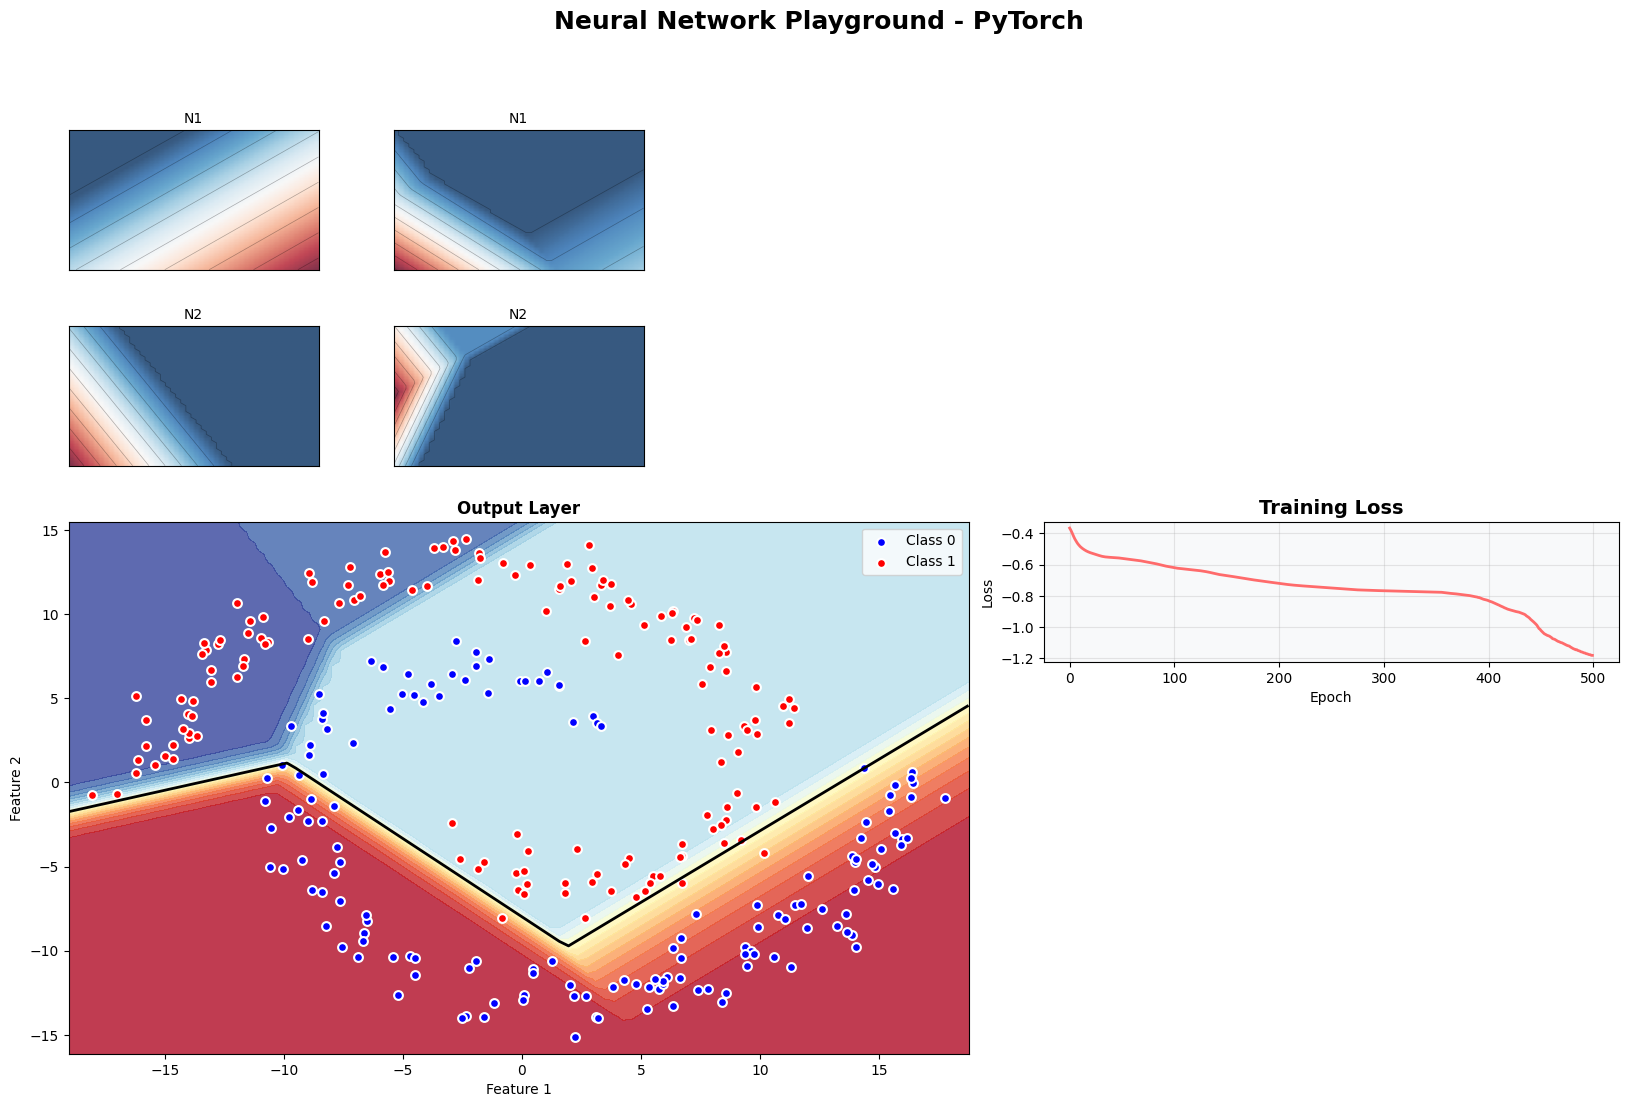

In [3]:
def simple_playground():
    print("🧠 Neural Network Playground - Simple Interface\n")
    
    dataset = input("Dataset (circle/moons/spiral/xor/linear) [circle]: ") or "circle"
    activation = input("Activation (tanh/relu/sigmoid) [tanh]: ") or "tanh"
    lr = float(input("Learning Rate [0.01]: ") or "0.01")
    epochs = int(input("Epochs [500]: ") or "500")
    h1 = int(input("Hidden Layer 1 neurons [6]: ") or "6")
    h2 = int(input("Hidden Layer 2 neurons [4]: ") or "4")
    
    train_network(
        dataset_type=dataset,
        hidden_layers=[h1, h2],
        activation=activation,
        learning_rate=lr,
        epochs=epochs
    )

# Запуск
simple_playground()

In [11]:
"""
Neural Network Playground - Tkinter Application
Интерактивная визуализация обучения нейронной сети с плавной анимацией
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from matplotlib.figure import Figure
from sklearn.datasets import make_classification, make_circles, make_moons
import tkinter as tk
from tkinter import ttk
import threading

# Установка случайного seed
torch.manual_seed(42)
np.random.seed(42)

class NeuralNetwork(nn.Module):
	"""Нейронная сеть с возможностью получения активаций"""
	def __init__(self, input_size=2, hidden_layers=[4, 4], activation='tanh'):
		super(NeuralNetwork, self).__init__()
		
		self.layers = nn.ModuleList()
		self.activations = []
		self.activation_type = activation
		
		prev_size = input_size
		
		for hidden_size in hidden_layers:
			self.layers.append(nn.Linear(prev_size, hidden_size))
			if activation == 'tanh':
				self.activations.append(nn.Tanh())
			elif activation == 'relu':
				self.activations.append(nn.ReLU())
			elif activation == 'sigmoid':
				self.activations.append(nn.Sigmoid())
			prev_size = hidden_size
		
		self.layers.append(nn.Linear(prev_size, 1))
		self.output_activation = nn.Sigmoid()
		
		self.layer_outputs = []
	
	def forward(self, x):
		self.layer_outputs = []
		
		for layer, activation in zip(self.layers[:-1], self.activations):
			x = layer(x)
			x = activation(x)
			self.layer_outputs.append(x.detach().clone())
		
		x = self.layers[-1](x)
		x = self.output_activation(x)
		self.layer_outputs.append(x.detach().clone())
		
		return x

def generate_dataset(dataset_type='circle', n_samples=200, noise=0.1):
	"""Генерация различных типов датасетов"""
	if dataset_type == 'circle':
		X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
	elif dataset_type == 'xor':
		X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
								   n_informative=2, n_clusters_per_class=1,
								   flip_y=0.1, class_sep=0.5)
	elif dataset_type == 'moons':
		X, y = make_moons(n_samples=n_samples, noise=noise)
	elif dataset_type == 'spiral':
		n = n_samples // 2
		theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
		r_a = 2 * theta + np.pi
		data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
		x_a = data_a + np.random.randn(n, 2) * noise
		
		theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
		r_b = -2 * theta - np.pi
		data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
		x_b = data_b + np.random.randn(n, 2) * noise
		
		X = np.vstack([x_a, x_b])
		y = np.hstack([np.zeros(n), np.ones(n)])
	else:  # linear
		X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
								   n_informative=2, n_clusters_per_class=1)
	
	return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)

class NeuralNetworkPlayground:
	def __init__(self, root):
		self.root = root
		self.root.title("Neural Network Playground - PyTorch")
		self.root.geometry("1600x900")
		
		# Переменные для обучения
		self.model = None
		self.X = None
		self.y = None
		self.optimizer = None
		self.criterion = nn.BCELoss()
		self.loss_history = []
		self.accuracy_history = []
		self.is_training = False
		self.training_thread = None
		
		# Создание интерфейса
		self.create_widgets()
		
	def create_widgets(self):
		# Левая панель управления
		control_frame = ttk.Frame(self.root, padding="10")
		control_frame.grid(row=0, column=0, sticky=(tk.W, tk.E, tk.N, tk.S))
		
		# Заголовок
		title_label = ttk.Label(control_frame, text="Neural Network Playground", 
								font=('Arial', 16, 'bold'))
		title_label.grid(row=0, column=0, columnspan=2, pady=10)
		
		# Dataset
		ttk.Label(control_frame, text="Dataset:").grid(row=1, column=0, sticky=tk.W, pady=5)
		self.dataset_var = tk.StringVar(value='circle')
		dataset_combo = ttk.Combobox(control_frame, textvariable=self.dataset_var,
									 values=['circle', 'moons', 'spiral', 'xor', 'linear'],
									 state='readonly', width=15)
		dataset_combo.grid(row=1, column=1, pady=5)
		
		# Activation
		ttk.Label(control_frame, text="Activation:").grid(row=2, column=0, sticky=tk.W, pady=5)
		self.activation_var = tk.StringVar(value='tanh')
		activation_combo = ttk.Combobox(control_frame, textvariable=self.activation_var,
										values=['tanh', 'relu', 'sigmoid'],
										state='readonly', width=15)
		activation_combo.grid(row=2, column=1, pady=5)
		
		# Learning Rate
		ttk.Label(control_frame, text="Learning Rate:").grid(row=3, column=0, sticky=tk.W, pady=5)
		self.lr_var = tk.DoubleVar(value=0.01)
		lr_scale = ttk.Scale(control_frame, from_=0.001, to=0.1, 
							 variable=self.lr_var, orient=tk.HORIZONTAL, length=150)
		lr_scale.grid(row=3, column=1, pady=5)
		self.lr_label = ttk.Label(control_frame, text="0.01")
		self.lr_label.grid(row=4, column=1, sticky=tk.W)
		lr_scale.configure(command=lambda v: self.lr_label.config(text=f"{float(v):.4f}"))
		
		# Hidden Layer 1
		ttk.Label(control_frame, text="Hidden Layer 1:").grid(row=5, column=0, sticky=tk.W, pady=5)
		self.h1_var = tk.IntVar(value=6)
		h1_scale = ttk.Scale(control_frame, from_=2, to=8, 
							 variable=self.h1_var, orient=tk.HORIZONTAL, length=150)
		h1_scale.grid(row=5, column=1, pady=5)
		self.h1_label = ttk.Label(control_frame, text="6")
		self.h1_label.grid(row=6, column=1, sticky=tk.W)
		h1_scale.configure(command=lambda v: self.h1_label.config(text=str(int(float(v)))))
		
		# Hidden Layer 2
		ttk.Label(control_frame, text="Hidden Layer 2:").grid(row=7, column=0, sticky=tk.W, pady=5)
		self.h2_var = tk.IntVar(value=4)
		h2_scale = ttk.Scale(control_frame, from_=2, to=8, 
							 variable=self.h2_var, orient=tk.HORIZONTAL, length=150)
		h2_scale.grid(row=7, column=1, pady=5)
		self.h2_label = ttk.Label(control_frame, text="4")
		self.h2_label.grid(row=8, column=1, sticky=tk.W)
		h2_scale.configure(command=lambda v: self.h2_label.config(text=str(int(float(v)))))
		
		# Кнопки
		self.start_button = ttk.Button(control_frame, text="▶ Start Training", 
									   command=self.start_training, width=20)
		self.start_button.grid(row=9, column=0, columnspan=2, pady=20)
		
		self.stop_button = ttk.Button(control_frame, text="⏸ Pause Training", 
									  command=self.stop_training, width=20, state='disabled')
		self.stop_button.grid(row=10, column=0, columnspan=2, pady=5)
		
		self.reset_button = ttk.Button(control_frame, text="🔄 Reset", 
									   command=self.reset_network, width=20)
		self.reset_button.grid(row=11, column=0, columnspan=2, pady=5)
		
		# Информация
		self.info_text = tk.Text(control_frame, height=10, width=25, state='disabled')
		self.info_text.grid(row=12, column=0, columnspan=2, pady=20)
		
		# Правая панель с графиками
		self.canvas_frame = ttk.Frame(self.root)
		self.canvas_frame.grid(row=0, column=1, sticky=(tk.W, tk.E, tk.N, tk.S))
		
		# Создание matplotlib figure
		self.fig = Figure(figsize=(14, 8))
		self.canvas = FigureCanvasTkAgg(self.fig, master=self.canvas_frame)
		self.canvas.get_tk_widget().pack(fill=tk.BOTH, expand=True)
		
		# Настройка grid weights
		self.root.columnconfigure(1, weight=1)
		self.root.rowconfigure(0, weight=1)
		
		# Инициализация сети
		self.reset_network()
	
	def update_info(self, text):
		"""Обновление информационного текста"""
		self.info_text.config(state='normal')
		self.info_text.delete(1.0, tk.END)
		self.info_text.insert(1.0, text)
		self.info_text.config(state='disabled')
	
	def reset_network(self):
		"""Сброс и инициализация новой сети"""
		if self.is_training:
			self.stop_training()
		
		# Генерация данных
		self.X, self.y = generate_dataset(self.dataset_var.get())
		
		# Создание модели
		hidden_layers = [self.h1_var.get(), self.h2_var.get()]
		self.model = NeuralNetwork(input_size=2, hidden_layers=hidden_layers,
								   activation=self.activation_var.get())
		
		self.optimizer = optim.Adam(self.model.parameters(), lr=self.lr_var.get())
		self.loss_history = []
		self.accuracy_history = []
		
		self.update_info("Network initialized!\nPress 'Start Training' to begin.")
		self.visualize_network()
	
	def start_training(self):
		"""Запуск обучения в отдельном потоке"""
		if not self.is_training:
			self.is_training = True
			self.start_button.config(state='disabled')
			self.stop_button.config(state='normal')
			self.training_thread = threading.Thread(target=self.training_loop, daemon=True)
			self.training_thread.start()
	
	def stop_training(self):
		"""Остановка обучения"""
		self.is_training = False
		self.start_button.config(state='normal')
		self.stop_button.config(state='disabled')
	
	def training_loop(self):
		"""Основной цикл обучения"""
		epoch = 0
		while self.is_training:
			# Прямой проход
			outputs = self.model(self.X)
			loss = self.criterion(outputs, self.y)
			
			# Обратное распространение
			self.optimizer.zero_grad()
			loss.backward()
			self.optimizer.step()
			
			# Расчет точности
			predicted = (outputs > 0.5).float()
			accuracy = (predicted == self.y).float().mean()
			
			self.loss_history.append(loss.item())
			self.accuracy_history.append(accuracy.item())
			
			epoch += 1
			
			# Обновление визуализации каждые 5 эпох
			if epoch % 5 == 0:
				info_text = f"Epoch: {epoch}\n"
				info_text += f"Loss: {loss.item():.4f}\n"
				info_text += f"Accuracy: {accuracy.item():.4f}\n"
				info_text += f"\nArchitecture:\n"
				info_text += f"  Input: 2\n"
				info_text += f"  Hidden 1: {self.h1_var.get()}\n"
				info_text += f"  Hidden 2: {self.h2_var.get()}\n"
				info_text += f"  Output: 1\n"
				
				self.root.after(0, self.update_info, info_text)
				self.root.after(0, self.visualize_network)
			
			# Небольшая задержка для плавности
			import time
			time.sleep(0.01)
	
	def visualize_network(self):
		"""Визуализация сети"""
		self.fig.clear()
		
		hidden_layers = [self.h1_var.get(), self.h2_var.get()]
		num_layers = len(hidden_layers)
		max_neurons = max(hidden_layers)
		
		# Получаем активации
		with torch.no_grad():
			_ = self.model(self.X)
		
		# Создание сетки GridSpec
		from matplotlib.gridspec import GridSpec
		gs = GridSpec(max_neurons + 2, num_layers + 2, figure=self.fig, 
					  hspace=0.4, wspace=0.3)
		
		# Визуализация скрытых слоев
		for layer_idx, num_neurons in enumerate(hidden_layers):
			for neuron_idx in range(num_neurons):
				ax = self.fig.add_subplot(gs[neuron_idx, layer_idx])
				self.plot_neuron_activation(ax, layer_idx, neuron_idx)
		
		# Выходной слой
		ax_output = self.fig.add_subplot(gs[:max_neurons, num_layers])
		self.plot_decision_boundary(ax_output)
		
		# Графики метрик
		if len(self.loss_history) > 0:
			# Loss
			ax_loss = self.fig.add_subplot(gs[:max_neurons//2, num_layers+1])
			ax_loss.plot(self.loss_history, color='#FF6B6B', linewidth=2)
			ax_loss.set_title('Loss', fontweight='bold', fontsize=10)
			ax_loss.set_xlabel('Epoch', fontsize=8)
			ax_loss.tick_params(labelsize=8)
			ax_loss.grid(True, alpha=0.3)
			
			# Accuracy
			ax_acc = self.fig.add_subplot(gs[max_neurons//2:max_neurons, num_layers+1])
			ax_acc.plot(self.accuracy_history, color='#51CF66', linewidth=2)
			ax_acc.set_title('Accuracy', fontweight='bold', fontsize=10)
			ax_acc.set_xlabel('Epoch', fontsize=8)
			ax_acc.tick_params(labelsize=8)
			ax_acc.grid(True, alpha=0.3)
		
		self.fig.tight_layout()
		self.canvas.draw()
	
	def plot_neuron_activation(self, ax, layer_idx, neuron_idx, resolution=50):
		"""Визуализация активации нейрона"""
		x_min, x_max = float(self.X[:, 0].min() - 1), float(self.X[:, 0].max() + 1)
		y_min, y_max = float(self.X[:, 1].min() - 1), float(self.X[:, 1].max() + 1)
		
		xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
							 np.linspace(y_min, y_max, resolution))
		
		grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
		
		with torch.no_grad():
			# Пропускаем grid через модель, чтобы получить активации для сетки
			x = grid
			for i, (layer, activation) in enumerate(zip(self.model.layers[:-1], self.model.activations)):
				x = layer(x)
				x = activation(x)
				if i == layer_idx:
					Z = x[:, neuron_idx].numpy()
					Z = Z.reshape(resolution, resolution)
					break
		
		ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], 
				  origin='lower', cmap='RdBu_r', alpha=0.8, aspect='auto')
		ax.set_xticks([])
		ax.set_yticks([])
		ax.set_title(f'N{neuron_idx+1}', fontsize=8)
	
	def plot_decision_boundary(self, ax, resolution=100):
		"""Визуализация границы решения"""
		x_min, x_max = float(self.X[:, 0].min() - 1), float(self.X[:, 0].max() + 1)
		y_min, y_max = float(self.X[:, 1].min() - 1), float(self.X[:, 1].max() + 1)
		
		xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
							 np.linspace(y_min, y_max, resolution))
		
		grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
		
		with torch.no_grad():
			Z = self.model(grid).numpy()
			Z = Z.reshape(resolution, resolution)
		
		ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.8)
		ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
		
		X_np, y_np = self.X.numpy(), self.y.numpy().flatten()
		ax.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], 
				   c='blue', s=30, edgecolors='white', linewidths=1)
		ax.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], 
				   c='red', s=30, edgecolors='white', linewidths=1)
		
		ax.set_title('Output', fontweight='bold')
		ax.set_xticks([])
		ax.set_yticks([])

def main():
	root = tk.Tk()
	app = NeuralNetworkPlayground(root)
	root.mainloop()

main()

/tmp/ipykernel_41013/3680914443.py:328: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  self.fig.tight_layout()
Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.12/tkinter/__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.12/tkinter/__init__.py", line 861, in callit
    func(*args)
  File "/tmp/ipykernel_41013/3680914443.py", line 304, in visualize_network
    self.plot_neuron_activation(ax, layer_idx, neuron_idx)
  File "/tmp/ipykernel_41013/3680914443.py", line 348, in plot_neuron_activation
    Z = x[:, neuron_idx].numpy()
        ~^^^^^^^^^^^^^^^
IndexError: index 4 is out of bounds for dimension 1 with size 4
Exception in Tkinter callback
Traceback (most recent call last):
  File "/usr/lib/python3.12/tkinter/__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "

In [2]:
"""
Neural Network Playground - PyTorch Implementation
Интерактивная визуализация обучения нейронной сети с автоматическим обновлением
"""

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from IPython.display import display, clear_output
import ipywidgets as widgets
from sklearn.datasets import make_classification, make_circles, make_moons
import threading
import time

# Установка случайного seed для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

# Глобальные переменные для состояния обучения
training_state = {
	'is_training': False,
	'epoch': 0,
	'loss_history': [],
	'accuracy_history': [],
	'model': None,
	'X': None,
	'y': None,
	'optimizer': None,
	'criterion': None
}

class NeuralNetwork(nn.Module):
	"""Простая нейронная сеть с настраиваемой архитектурой"""
	def __init__(self, input_size=2, hidden_layers=[4, 4], activation='tanh'):
		super(NeuralNetwork, self).__init__()
		
		self.layers = nn.ModuleList()
		self.activations = []
		self.activation_type = activation
		
		prev_size = input_size
		
		# Скрытые слои
		for hidden_size in hidden_layers:
			self.layers.append(nn.Linear(prev_size, hidden_size))
			if activation == 'tanh':
				self.activations.append(nn.Tanh())
			elif activation == 'relu':
				self.activations.append(nn.ReLU())
			elif activation == 'sigmoid':
				self.activations.append(nn.Sigmoid())
			prev_size = hidden_size
		
		# Выходной слой
		self.layers.append(nn.Linear(prev_size, 1))
		self.output_activation = nn.Sigmoid()
		
		# Для хранения активаций
		self.layer_outputs = []
	
	def forward(self, x):
		self.layer_outputs = []
		
		for i, (layer, activation) in enumerate(zip(self.layers[:-1], self.activations)):
			x = layer(x)
			x = activation(x)
			self.layer_outputs.append(x.detach().clone())
		
		# Выходной слой
		x = self.layers[-1](x)
		x = self.output_activation(x)
		self.layer_outputs.append(x.detach().clone())
		
		return x

def generate_dataset(dataset_type='circle', n_samples=200, noise=0.1):
	"""Генерация различных типов датасетов"""
	if dataset_type == 'circle':
		X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
	elif dataset_type == 'xor':
		X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
								   n_informative=2, n_clusters_per_class=1,
								   flip_y=0.1, class_sep=0.5)
	elif dataset_type == 'moons':
		X, y = make_moons(n_samples=n_samples, noise=noise)
	elif dataset_type == 'spiral':
		n = n_samples // 2
		theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
		r_a = 2 * theta + np.pi
		data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
		x_a = data_a + np.random.randn(n, 2) * noise
		
		theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
		r_b = -2 * theta - np.pi
		data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
		x_b = data_b + np.random.randn(n, 2) * noise
		
		X = np.vstack([x_a, x_b])
		y = np.hstack([np.zeros(n), np.ones(n)])
	else:  # linear
		X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
								   n_informative=2, n_clusters_per_class=1)
	
	return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)

def plot_neuron_activation(model, X, neuron_idx, layer_idx, ax, resolution=50):
	"""Визуализация активации конкретного нейрона"""
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	
	xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
						 np.linspace(y_min, y_max, resolution))
	
	grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
	
	with torch.no_grad():
		# Пропускаем через слои до нужного
		x = grid
		for i, (layer, activation) in enumerate(zip(model.layers[:-1], model.activations)):
			x = layer(x)
			x = activation(x)
			if i == layer_idx:
				Z = x[:, neuron_idx].numpy().reshape(xx.shape)
				break
	
	# Отображение активации нейрона
	im = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], 
				   origin='lower', cmap='RdBu_r', alpha=0.8, aspect='auto')
	ax.contour(xx, yy, Z, levels=10, colors='black', linewidths=0.5, alpha=0.3)
	
	ax.set_xlim(x_min, x_max)
	ax.set_ylim(y_min, y_max)
	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_title(f'N{neuron_idx+1}', fontsize=10, pad=5)
	
	return im

def plot_decision_boundary(model, X, y, ax, resolution=100):
	"""Визуализация границы решения"""
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	
	xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
						 np.linspace(y_min, y_max, resolution))
	
	grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
	
	with torch.no_grad():
		Z = model(grid).numpy().reshape(xx.shape)
	
	ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.8)
	ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
	
	# Отображение точек данных
	X_np, y_np = X.numpy(), y.numpy().flatten()
	ax.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], 
			   c='blue', s=40, edgecolors='white', linewidths=1.5, label='Class 0')
	ax.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], 
			   c='red', s=40, edgecolors='white', linewidths=1.5, label='Class 1')
	
	ax.set_xlim(x_min, x_max)
	ax.set_ylim(y_min, y_max)
	ax.set_xlabel('Feature 1')
	ax.set_ylabel('Feature 2')
	ax.legend(loc='upper right')
	ax.set_title('Output Layer', fontweight='bold')

def visualize_network(fig):
	"""Визуализация всей сети с активациями нейронов"""
	fig.clear()
	
	if training_state['model'] is None:
		return
	
	model = training_state['model']
	X = training_state['X']
	y = training_state['y']
	loss_history = training_state['loss_history']
	accuracy_history = training_state['accuracy_history']
	
	# Подсчет количества нейронов в каждом слое
	hidden_layers = [layer.out_features for layer in model.layers[:-1]]
	num_layers = len(hidden_layers)
	max_neurons = max(hidden_layers) if hidden_layers else 0
	
	# Создание сетки для графиков
	gs = GridSpec(max_neurons + 3, num_layers + 3, figure=fig, hspace=0.4, wspace=0.3)
	
	# Получаем активации для всех нейронов
	with torch.no_grad():
		_ = model(X)
	
	# Визуализация скрытых слоев
	for layer_idx, num_neurons in enumerate(hidden_layers):
		for neuron_idx in range(num_neurons):
			ax = fig.add_subplot(gs[neuron_idx, layer_idx])
			plot_neuron_activation(model, X, neuron_idx, layer_idx, ax)
		
		# Заголовок слоя
		ax_title = fig.add_subplot(gs[max_neurons, layer_idx])
		ax_title.text(0.5, 0.5, f'Hidden Layer {layer_idx + 1}\n({num_neurons} neurons)', 
					  ha='center', va='center', fontsize=12, fontweight='bold')
		ax_title.axis('off')
	
	# Визуализация выходного слоя
	ax_output = fig.add_subplot(gs[:max_neurons, num_layers])
	plot_decision_boundary(model, X, y, ax_output)
	
	# График потерь
	if len(loss_history) > 0:
		ax_loss = fig.add_subplot(gs[:max_neurons//2, num_layers+1:])
		ax_loss.plot(loss_history, color='#FF6B6B', linewidth=2)
		ax_loss.set_title('Training Loss', fontweight='bold', fontsize=14)
		ax_loss.set_xlabel('Epoch')
		ax_loss.set_ylabel('Loss')
		ax_loss.grid(True, alpha=0.3)
		ax_loss.set_facecolor('#F8F9FA')
	
	# График точности
	if len(accuracy_history) > 0:
		ax_acc = fig.add_subplot(gs[max_neurons//2:max_neurons, num_layers+1:])
		ax_acc.plot(accuracy_history, color='#51CF66', linewidth=2)
		ax_acc.set_title('Training Accuracy', fontweight='bold', fontsize=14)
		ax_acc.set_xlabel('Epoch')
		ax_acc.set_ylabel('Accuracy')
		ax_acc.grid(True, alpha=0.3)
		ax_acc.set_facecolor('#F8F9FA')
	
	# Информация о модели
	ax_info = fig.add_subplot(gs[max_neurons:, num_layers+1:])
	info_text = f"Epoch: {training_state['epoch']}\n"
	info_text += f"Architecture: {[2] + hidden_layers + [1]}\n"
	info_text += f"Activation: {model.activation_type}\n"
	if len(loss_history) > 0:
		info_text += f"Current Loss: {loss_history[-1]:.4f}\n"
		info_text += f"Current Accuracy: {accuracy_history[-1]:.4f}\n"
	info_text += f"Status: {'🟢 Training' if training_state['is_training'] else '🔴 Stopped'}"
	ax_info.text(0.1, 0.5, info_text, ha='left', va='center', 
				 fontsize=11, family='monospace',
				 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
	ax_info.axis('off')
	
	plt.suptitle('Neural Network Playground - PyTorch', 
				 fontsize=18, fontweight='bold', y=0.98)

def training_loop():
	"""Фоновый процесс обучения"""
	while training_state['is_training']:
		# Прямой проход
		outputs = training_state['model'](training_state['X'])
		loss = training_state['criterion'](outputs, training_state['y'])
		
		# Обратное распространение
		training_state['optimizer'].zero_grad()
		loss.backward()
		training_state['optimizer'].step()
		
		# Расчет точности
		predicted = (outputs > 0.5).float()
		accuracy = (predicted == training_state['y']).float().mean()
		
		training_state['loss_history'].append(loss.item())
		training_state['accuracy_history'].append(accuracy.item())
		training_state['epoch'] += 1
		
		# Небольшая задержка
		time.sleep(0.01)

def create_interactive_playground():
	"""Создание интерактивного интерфейса с автообновлением"""
	
	# Виджеты управления
	dataset_widget = widgets.Dropdown(
		options=['circle', 'xor', 'moons', 'spiral', 'linear'],
		value='circle',
		description='Dataset:',
		style={'description_width': 'initial'}
	)
	
	activation_widget = widgets.Dropdown(
		options=['tanh', 'relu', 'sigmoid'],
		value='tanh',
		description='Activation:',
		style={'description_width': 'initial'}
	)
	
	lr_widget = widgets.FloatLogSlider(
		value=0.01,
		base=10,
		min=-4,
		max=-1,
		step=0.1,
		description='Learning Rate:',
		style={'description_width': 'initial'}
	)
	
	hidden1_widget = widgets.IntSlider(
		value=6,
		min=2,
		max=8,
		step=1,
		description='Hidden Layer 1:',
		style={'description_width': 'initial'}
	)
	
	hidden2_widget = widgets.IntSlider(
		value=4,
		min=2,
		max=8,
		step=1,
		description='Hidden Layer 2:',
		style={'description_width': 'initial'}
	)
	
	start_button = widgets.Button(
		description="▶ Start Training",
		button_style='success',
		layout=widgets.Layout(width='150px')
	)
	
	stop_button = widgets.Button(
		description="⏸ Stop Training",
		button_style='warning',
		layout=widgets.Layout(width='150px')
	)
	
	reset_button = widgets.Button(
		description="🔄 Reset",
		button_style='danger',
		layout=widgets.Layout(width='150px')
	)
	
	output = widgets.Output()
	
	# Создание фигуры matplotlib
	fig = plt.figure(figsize=(18, 10))
	
	def reset_network(b=None):
		"""Сброс сети"""
		training_state['is_training'] = False
		time.sleep(0.1)  # Даем время остановиться потоку
		
		training_state['X'], training_state['y'] = generate_dataset(dataset_widget.value)
		hidden_layers = [hidden1_widget.value, hidden2_widget.value]
		training_state['model'] = NeuralNetwork(
			input_size=2,
			hidden_layers=hidden_layers,
			activation=activation_widget.value
		)
		training_state['optimizer'] = optim.Adam(
			training_state['model'].parameters(),
			lr=lr_widget.value
		)
		training_state['criterion'] = nn.BCELoss()
		training_state['loss_history'] = []
		training_state['accuracy_history'] = []
		training_state['epoch'] = 0
		
		with output:
			visualize_network(fig)
			plt.show()
	
	def start_training(b):
		"""Запуск обучения"""
		if not training_state['is_training']:
			training_state['is_training'] = True
			thread = threading.Thread(target=training_loop, daemon=True)
			thread.start()
	
	def stop_training(b):
		"""Остановка обучения"""
		training_state['is_training'] = False
	
	def update_plot():
		"""Обновление графика (вызывается таймером)"""
		with output:
			clear_output(wait=True)
			visualize_network(fig)
			plt.show()
	
	# Привязка кнопок
	start_button.on_click(start_training)
	stop_button.on_click(stop_training)
	reset_button.on_click(reset_network)
	
	# Создание UI
	ui = widgets.VBox([
		widgets.HTML('<h2>🧠 Neural Network Playground - PyTorch</h2>'),
		widgets.HTML('<hr>'),
		widgets.HBox([dataset_widget, activation_widget]),
		widgets.HBox([lr_widget]),
		widgets.HBox([hidden1_widget, hidden2_widget]),
		widgets.HBox([start_button, stop_button, reset_button]),
		output
	])
	
	# Инициализация
	reset_network()
	
	# Автообновление каждые 33мс (30 FPS)
	import asyncio
	from IPython.display import display
	
	async def auto_update():
		while True:
			update_plot()
			await asyncio.sleep(0.033)  # ~30 FPS
	
	display(ui)
	
	# Запуск автообновления
	import nest_asyncio
	nest_asyncio.apply()
	
	loop = asyncio.get_event_loop()
	task = loop.create_task(auto_update())
	
	return ui, task

# Пример использования
print("=" * 70)
print("🧠 Neural Network Playground - PyTorch")
print("=" * 70)
print("\n📚 Запуск интерактивного интерфейса:")
print("ui, task = create_interactive_playground()")
print("\n💡 Для остановки автообновления:")
print("task.cancel()")
print("\n" + "=" * 70)

class NeuralNetwork(nn.Module):
	"""Простая нейронная сеть с настраиваемой архитектурой"""
	def __init__(self, input_size=2, hidden_layers=[4, 4], activation='tanh'):
		super(NeuralNetwork, self).__init__()
		
		self.layers = nn.ModuleList()
		self.activations = []
		self.activation_type = activation
		
		prev_size = input_size
		
		# Скрытые слои
		for hidden_size in hidden_layers:
			self.layers.append(nn.Linear(prev_size, hidden_size))
			if activation == 'tanh':
				self.activations.append(nn.Tanh())
			elif activation == 'relu':
				self.activations.append(nn.ReLU())
			elif activation == 'sigmoid':
				self.activations.append(nn.Sigmoid())
			prev_size = hidden_size
		
		# Выходной слой
		self.layers.append(nn.Linear(prev_size, 1))
		self.output_activation = nn.Sigmoid()
		
		# Для хранения активаций
		self.layer_outputs = []
	
	def forward(self, x):
		self.layer_outputs = []
		
		for i, (layer, activation) in enumerate(zip(self.layers[:-1], self.activations)):
			x = layer(x)
			x = activation(x)
			self.layer_outputs.append(x.detach().clone())
		
		# Выходной слой
		x = self.layers[-1](x)
		x = self.output_activation(x)
		self.layer_outputs.append(x.detach().clone())
		
		return x

def generate_dataset(dataset_type='circle', n_samples=200, noise=0.1):
	"""Генерация различных типов датасетов"""
	if dataset_type == 'circle':
		X, y = make_circles(n_samples=n_samples, noise=noise, factor=0.5)
	elif dataset_type == 'xor':
		X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
								   n_informative=2, n_clusters_per_class=1,
								   flip_y=0.1, class_sep=0.5)
	elif dataset_type == 'moons':
		X, y = make_moons(n_samples=n_samples, noise=noise)
	elif dataset_type == 'spiral':
		n = n_samples // 2
		theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
		r_a = 2 * theta + np.pi
		data_a = np.array([np.cos(theta) * r_a, np.sin(theta) * r_a]).T
		x_a = data_a + np.random.randn(n, 2) * noise
		
		theta = np.sqrt(np.random.rand(n)) * 2 * np.pi
		r_b = -2 * theta - np.pi
		data_b = np.array([np.cos(theta) * r_b, np.sin(theta) * r_b]).T
		x_b = data_b + np.random.randn(n, 2) * noise
		
		X = np.vstack([x_a, x_b])
		y = np.hstack([np.zeros(n), np.ones(n)])
	else:  # linear
		X, y = make_classification(n_samples=n_samples, n_features=2, n_redundant=0,
								   n_informative=2, n_clusters_per_class=1)
	
	return torch.FloatTensor(X), torch.FloatTensor(y).reshape(-1, 1)

def plot_neuron_activation(model, X, neuron_idx, layer_idx, ax, resolution=50):
	"""Визуализация активации конкретного нейрона"""
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	
	xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
						 np.linspace(y_min, y_max, resolution))
	
	grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
	
	with torch.no_grad():
		_ = model(grid)
		activations = model.layer_outputs[layer_idx]
		Z = activations[:, neuron_idx].numpy().reshape(xx.shape)
	
	# Отображение активации нейрона
	im = ax.imshow(Z, extent=[x_min, x_max, y_min, y_max], 
				   origin='lower', cmap='RdBu_r', alpha=0.8, aspect='auto')
	ax.contour(xx, yy, Z, levels=10, colors='black', linewidths=0.5, alpha=0.3)
	
	ax.set_xlim(x_min, x_max)
	ax.set_ylim(y_min, y_max)
	ax.set_xticks([])
	ax.set_yticks([])
	ax.set_title(f'N{neuron_idx+1}', fontsize=10, pad=5)
	
	return im

def plot_decision_boundary(model, X, y, ax, resolution=100):
	"""Визуализация границы решения"""
	x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
	y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
	
	xx, yy = np.meshgrid(np.linspace(x_min, x_max, resolution),
						 np.linspace(y_min, y_max, resolution))
	
	grid = torch.FloatTensor(np.c_[xx.ravel(), yy.ravel()])
	
	with torch.no_grad():
		Z = model(grid).numpy().reshape(xx.shape)
	
	ax.contourf(xx, yy, Z, levels=20, cmap='RdYlBu', alpha=0.8)
	ax.contour(xx, yy, Z, levels=[0.5], colors='black', linewidths=2)
	
	# Отображение точек данных
	X_np, y_np = X.numpy(), y.numpy().flatten()
	ax.scatter(X_np[y_np == 0, 0], X_np[y_np == 0, 1], 
			   c='blue', s=40, edgecolors='white', linewidths=1.5, label='Class 0')
	ax.scatter(X_np[y_np == 1, 0], X_np[y_np == 1, 1], 
			   c='red', s=40, edgecolors='white', linewidths=1.5, label='Class 1')
	
	ax.set_xlim(x_min, x_max)
	ax.set_ylim(y_min, y_max)
	ax.set_xlabel('Feature 1')
	ax.set_ylabel('Feature 2')
	ax.legend(loc='upper right')
	ax.set_title('Output Layer', fontweight='bold')

def visualize_network(model, X, y, loss_history, accuracy_history):
	"""Визуализация всей сети с активациями нейронов"""
	
	# Подсчет количества нейронов в каждом слое
	hidden_layers = [layer.out_features for layer in model.layers[:-1]]
	num_layers = len(hidden_layers)
	max_neurons = max(hidden_layers) if hidden_layers else 0
	
	# Создание сетки для графиков
	fig = plt.figure(figsize=(20, 12))
	gs = GridSpec(max_neurons + 3, num_layers + 3, figure=fig, hspace=0.4, wspace=0.3)
	
	# Получаем активации для всех нейронов
	with torch.no_grad():
		_ = model(X)
	
	# Визуализация скрытых слоев
	for layer_idx, num_neurons in enumerate(hidden_layers):
		for neuron_idx in range(num_neurons):
			ax = fig.add_subplot(gs[neuron_idx, layer_idx])
			plot_neuron_activation(model, X, neuron_idx, layer_idx, ax)
		
		# Заголовок слоя
		ax_title = fig.add_subplot(gs[max_neurons, layer_idx])
		ax_title.text(0.5, 0.5, f'Hidden Layer {layer_idx + 1}\n({num_neurons} neurons)', 
					  ha='center', va='center', fontsize=12, fontweight='bold')
		ax_title.axis('off')
	
	# Визуализация выходного слоя
	ax_output = fig.add_subplot(gs[:max_neurons, num_layers])
	plot_decision_boundary(model, X, y, ax_output)
	
	# График потерь
	ax_loss = fig.add_subplot(gs[:max_neurons//2, num_layers+1:])
	ax_loss.plot(loss_history, color='#FF6B6B', linewidth=2)
	ax_loss.set_title('Training Loss', fontweight='bold', fontsize=14)
	ax_loss.set_xlabel('Epoch')
	ax_loss.set_ylabel('Loss')
	ax_loss.grid(True, alpha=0.3)
	ax_loss.set_facecolor('#F8F9FA')
	
	# График точности
	ax_acc = fig.add_subplot(gs[max_neurons//2:max_neurons, num_layers+1:])
	ax_acc.plot(accuracy_history, color='#51CF66', linewidth=2)
	ax_acc.set_title('Training Accuracy', fontweight='bold', fontsize=14)
	ax_acc.set_xlabel('Epoch')
	ax_acc.set_ylabel('Accuracy')
	ax_acc.grid(True, alpha=0.3)
	ax_acc.set_facecolor('#F8F9FA')
	
	# Информация о модели
	ax_info = fig.add_subplot(gs[max_neurons:, num_layers+1:])
	info_text = f"Architecture: {[2] + hidden_layers + [1]}\n"
	info_text += f"Activation: {model.activation_type}\n"
	info_text += f"Final Loss: {loss_history[-1]:.4f}\n"
	info_text += f"Final Accuracy: {accuracy_history[-1]:.4f}\n"
	info_text += f"Total Parameters: {sum(p.numel() for p in model.parameters())}"
	ax_info.text(0.1, 0.5, info_text, ha='left', va='center', 
				 fontsize=11, family='monospace',
				 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.3))
	ax_info.axis('off')
	
	plt.suptitle('Neural Network Playground - PyTorch', 
				 fontsize=18, fontweight='bold', y=0.98)
	
	return fig

def train_network(dataset_type='circle', hidden_layers=[4, 4], 
				 activation='tanh', learning_rate=0.01, 
				 epochs=1000, plot_every=50):
	"""Обучение нейронной сети с визуализацией"""
	
	# Генерация данных
	X, y = generate_dataset(dataset_type)
	
	# Создание модели
	model = NeuralNetwork(input_size=2, hidden_layers=hidden_layers, 
						 activation=activation)
	
	# Функция потерь и оптимизатор
	criterion = nn.BCELoss()
	optimizer = optim.Adam(model.parameters(), lr=learning_rate)
	
	# История обучения
	loss_history = []
	accuracy_history = []
	
	print(f"🚀 Обучение начато...")
	print(f"📊 Dataset: {dataset_type}")
	print(f"🧠 Architecture: {[2] + hidden_layers + [1]}")
	print(f"⚡ Activation: {activation}")
	print(f"📈 Learning Rate: {learning_rate}")
	print("-" * 70)
	
	for epoch in range(epochs):
		# Прямой проход
		outputs = model(X)
		loss = criterion(outputs, y)
		
		# Обратное распространение
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()
		
		# Расчет точности
		predicted = (outputs > 0.5).float()
		accuracy = (predicted == y).float().mean()
		
		loss_history.append(loss.item())
		accuracy_history.append(accuracy.item())
		
		# Визуализация
		if (epoch + 1) % plot_every == 0 or epoch == 0:
			print(f"Epoch {epoch+1:4d}/{epochs} - Loss: {loss.item():.4f}, "
				  f"Accuracy: {accuracy.item():.4f}")
			
			clear_output(wait=True)
			
			fig = visualize_network(model, X, y, loss_history, accuracy_history)
			plt.show()
			
			print(f"\n🎯 Epoch {epoch+1}/{epochs}")
			print(f"📉 Loss: {loss.item():.4f}")
			print(f"🎯 Accuracy: {accuracy.item():.4f}")
			print("-" * 70)
	
	print("\n✅ Обучение завершено!")
	print(f"📉 Финальная Loss: {loss_history[-1]:.4f}")
	print(f"🎯 Финальная Accuracy: {accuracy_history[-1]:.4f}")
	
	# Финальная визуализация
	clear_output(wait=True)
	fig = visualize_network(model, X, y, loss_history, accuracy_history)
	plt.show()
	
	return model, loss_history, accuracy_history

# Интерактивные виджеты для настройки параметров
def create_interactive_playground():
	"""Создание интерактивного интерфейса"""
	
	dataset_widget = widgets.Dropdown(
		options=['circle', 'xor', 'moons', 'spiral', 'linear'],
		value='circle',
		description='Dataset:',
		style={'description_width': 'initial'}
	)
	
	activation_widget = widgets.Dropdown(
		options=['tanh', 'relu', 'sigmoid'],
		value='tanh',
		description='Activation:',
		style={'description_width': 'initial'}
	)
	
	lr_widget = widgets.FloatLogSlider(
		value=0.01,
		base=10,
		min=-4,
		max=-1,
		step=0.1,
		description='Learning Rate:',
		style={'description_width': 'initial'}
	)
	
	epochs_widget = widgets.IntSlider(
		value=500,
		min=100,
		max=2000,
		step=100,
		description='Epochs:',
		style={'description_width': 'initial'}
	)
	
	hidden1_widget = widgets.IntSlider(
		value=4,
		min=2,
		max=8,
		step=1,
		description='Hidden Layer 1:',
		style={'description_width': 'initial'}
	)
	
	hidden2_widget = widgets.IntSlider(
		value=4,
		min=2,
		max=8,
		step=1,
		description='Hidden Layer 2:',
		style={'description_width': 'initial'}
	)
	
	button = widgets.Button(
		description="🚀 Train Network",
		button_style='success',
		layout=widgets.Layout(width='200px', height='40px')
	)
	output = widgets.Output()
	
	def on_button_click(b):
		with output:
			clear_output()
			hidden_layers = [hidden1_widget.value, hidden2_widget.value]
			train_network(
				dataset_type=dataset_widget.value,
				hidden_layers=hidden_layers,
				activation=activation_widget.value,
				learning_rate=lr_widget.value,
				epochs=epochs_widget.value,
				plot_every=50
			)
	
	button.on_click(on_button_click)
	
	ui = widgets.VBox([
		widgets.HTML('<h2>🧠 Neural Network Playground - PyTorch</h2>'),
		widgets.HTML('<hr>'),
		widgets.HBox([dataset_widget, activation_widget]),
		widgets.HBox([lr_widget, epochs_widget]),
		widgets.HBox([hidden1_widget, hidden2_widget]),
		button,
		output
	])
	
	display(ui)

# Пример использования
print("=" * 70)
print("🧠 Neural Network Playground - PyTorch")
print("=" * 70)
print("\n📚 Доступные функции:")
print("1. train_network() - обучение с параметрами по умолчанию")
print("2. create_interactive_playground() - интерактивный интерфейс")
print("\n💡 Пример использования:")
print("model, loss, acc = train_network(")
print("    dataset_type='circle',")
print("    hidden_layers=[6, 4],")
print("    activation='tanh',")
print("    learning_rate=0.01,")
print("    epochs=500")
print(")")
print("\n" + "=" * 70)

🧠 Neural Network Playground - PyTorch

📚 Запуск интерактивного интерфейса:
ui, task = create_interactive_playground()

💡 Для остановки автообновления:
task.cancel()

🧠 Neural Network Playground - PyTorch

📚 Доступные функции:
1. train_network() - обучение с параметрами по умолчанию
2. create_interactive_playground() - интерактивный интерфейс

💡 Пример использования:
model, loss, acc = train_network(
    dataset_type='circle',
    hidden_layers=[6, 4],
    activation='tanh',
    learning_rate=0.01,
    epochs=500
)



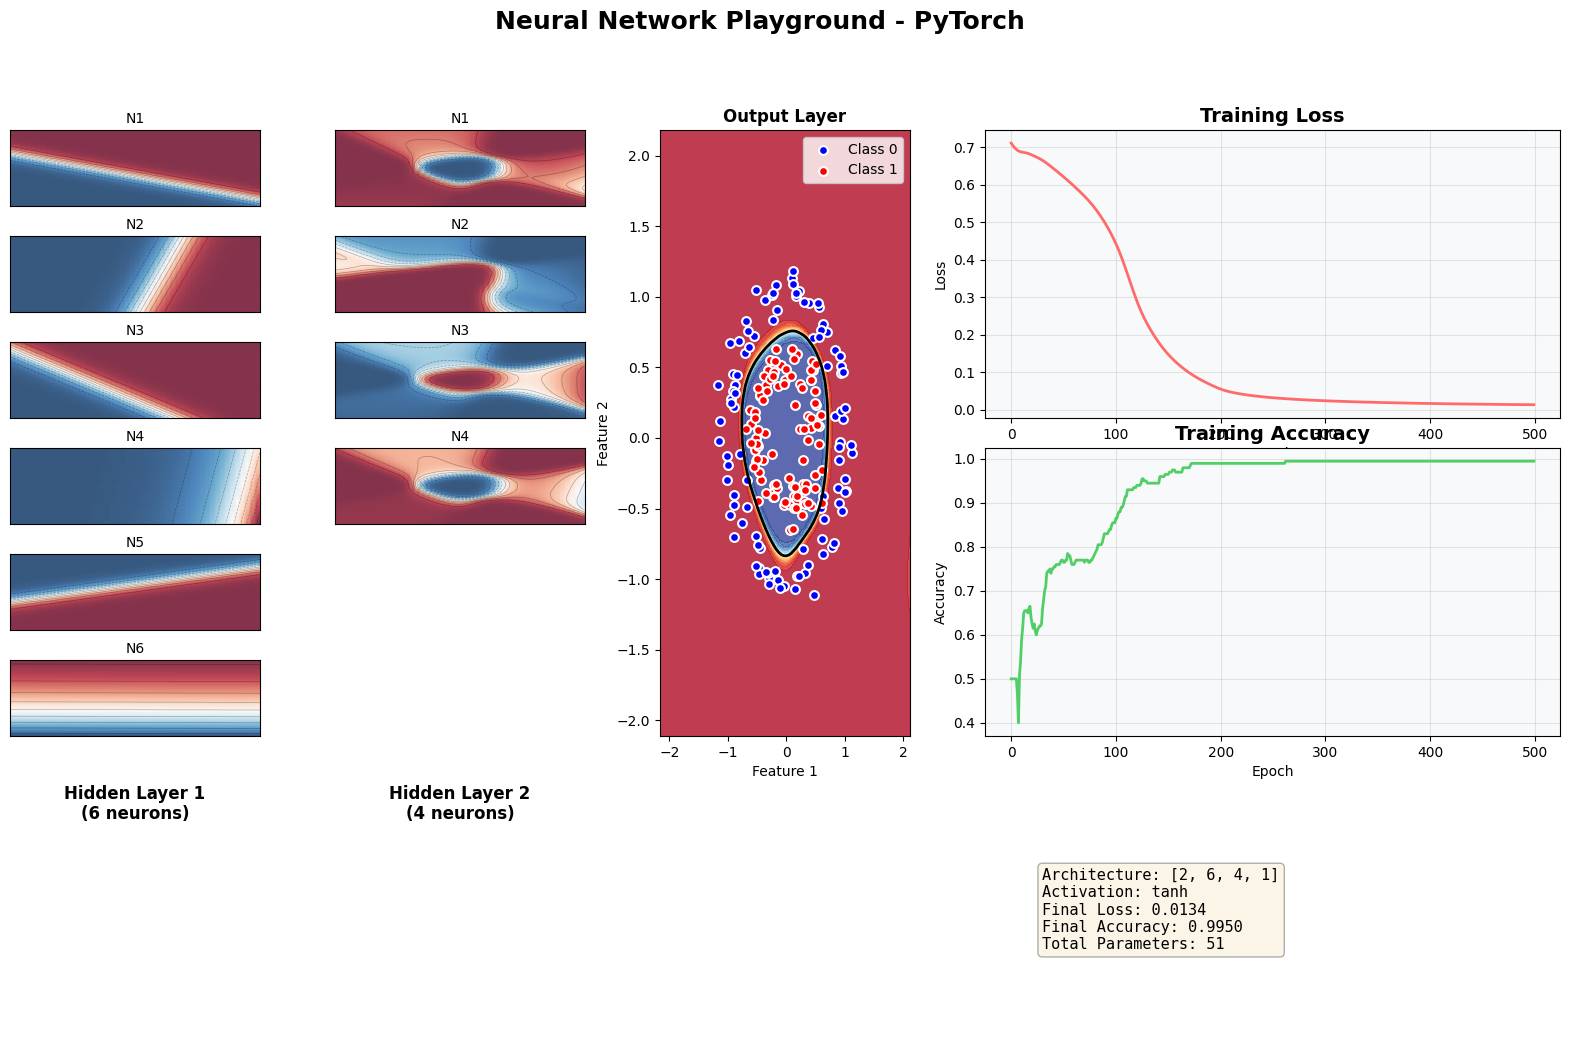

(NeuralNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=2, out_features=6, bias=True)
     (1): Linear(in_features=6, out_features=4, bias=True)
     (2): Linear(in_features=4, out_features=1, bias=True)
   )
   (output_activation): Sigmoid()
 ),
 [0.7113037109375,
  0.7071222066879272,
  0.7033498883247375,
  0.699979841709137,
  0.6969988346099854,
  0.6944081783294678,
  0.6922214031219482,
  0.6904481649398804,
  0.6890822052955627,
  0.6880891919136047,
  0.6873999834060669,
  0.6869078874588013,
  0.6864885687828064,
  0.6860308051109314,
  0.6854577660560608,
  0.6847326755523682,
  0.6838532090187073,
  0.6828408241271973,
  0.6817290782928467,
  0.6805523633956909,
  0.6793379783630371,
  0.6781008243560791,
  0.6768450736999512,
  0.675566554069519,
  0.6742562055587769,
  0.672902524471283,
  0.6714934706687927,
  0.6700180768966675,
  0.6684674620628357,
  0.6668358445167542,
  0.6651204824447632,
  0.6633216738700867,
  0.6614429354667664,
  0.659490048885345

In [3]:
# Запуск обучения с параметрами по умолчанию
train_network(dataset_type='circle', hidden_layers=[6, 4], 
			 activation='tanh', learning_rate=0.01, epochs=500, plot_every=50)

# учим оффлайн

In [27]:
def train_network(X, y, learning_rate=0.001, batch_size=16, epochs=1000, device='cpu'):
	global model
	global loss_history
	global accuracy_history

	"""Обучение нейронной сети с визуализацией"""

	# Функция потерь и оптимизатор
	criterion = nn.BCELoss()
	optimizer = optim.Adam(model.parameters(), lr=learning_rate)
	#optimizer = optim.SGD(model.parameters(), lr=learning_rate)

	# История обучения
	loss_history = []
	accuracy_history = []

	train_set = TensorDataset(torch.tensor(X, dtype=DTYPE).to(device), torch.tensor(y, dtype=DTYPE).to(device))
	loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

	prog_bar = tqdm(range(epochs), total=epochs, desc='start', leave=True)
	for epoch in prog_bar: #trange(epochs):
		mean_loss = 0
		n_batch = 0
		for X,y in loader:
			# Прямой проход
			outputs = model(X)
			loss = criterion(outputs, y)

			# Обратное распространение
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			mean_loss += loss.item()
			n_batch +=1

		# Расчет точности
		#predicted = (outputs > 0.5).float()
		#accuracy = (predicted == y).float().mean()

		loss_history.append(mean_loss/n_batch)
		#accuracy_history.append(accuracy.item())

		desc = f'{epoch} Loss: {mean_loss/n_batch:.4}'
		prog_bar.set_description(desc, refresh=True)

model = FeedForward(2,[20,20,20],nn.ReLU())
train_network(X,y)

start:   0%|          | 0/1000 [00:00<?, ?it/s]

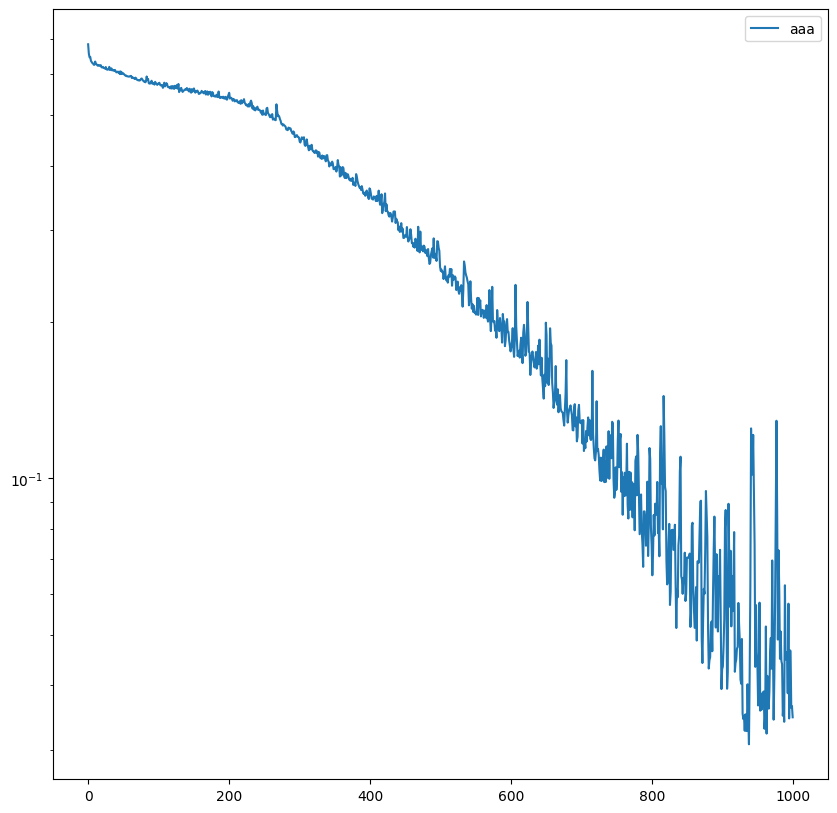

In [28]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.plot(loss_history, label='aaa')
plt.yscale("log")
ax.legend()
plt.show()

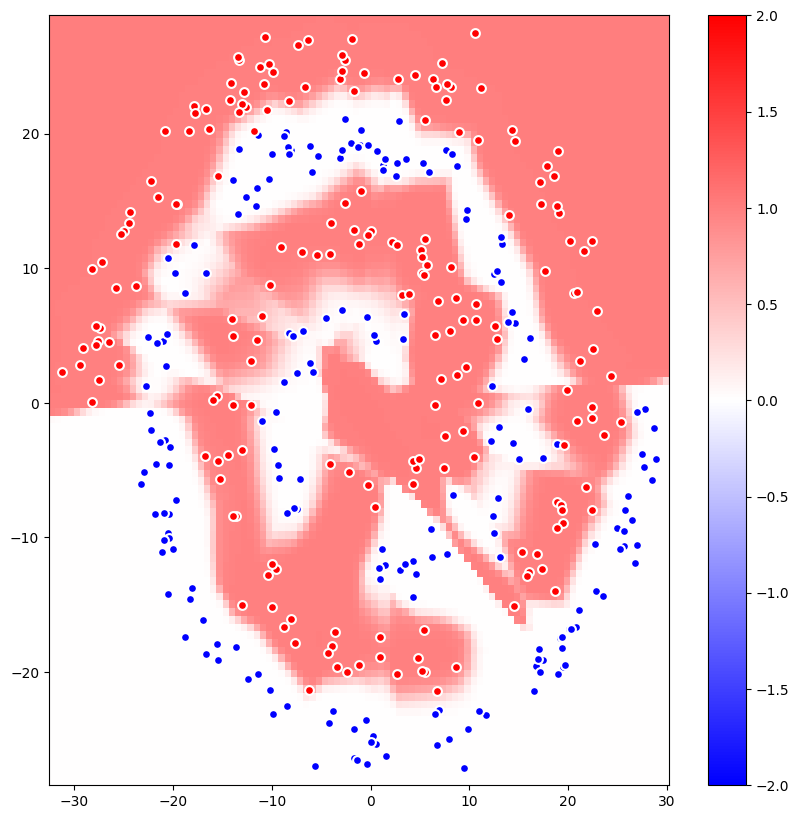

In [29]:
fig, ax = plt.subplots(figsize=(10, 10))
tmp = draw_mesh(model,ax,x_min, y_min, x_max, y_max, cmin=-2, cmax=2)
plt.colorbar(tmp, ax=ax)
draw_dots(X,y,ax)

plt.show()

# функции активации

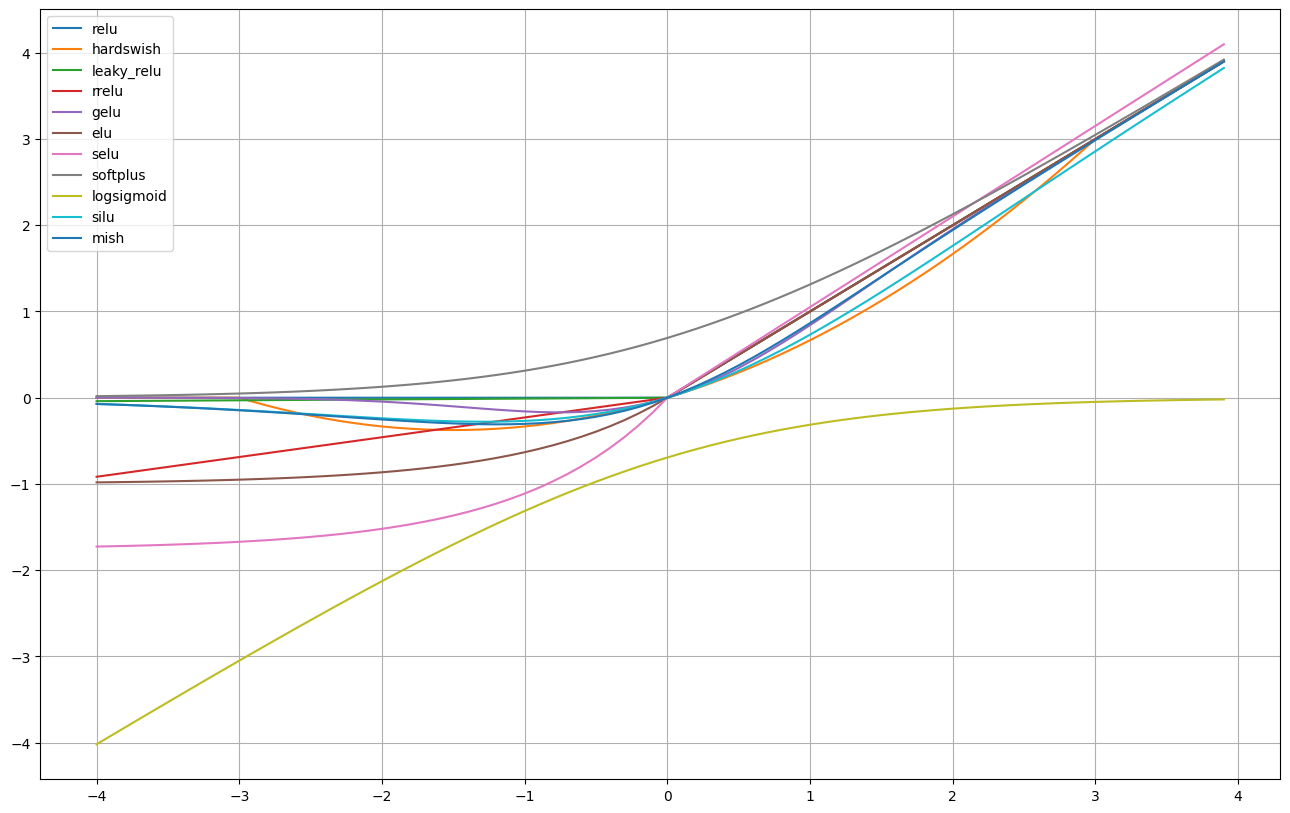

In [99]:
x = torch.arange(-4,4,0.1)

fig, ax = plt.subplots(figsize=(16, 10))

#ax.plot(x,Fun.threshold(x), label='threshold')
#ax.plot(x,Fun.prelu(x), label='prelu')
#ax.plot(x,Fun.glu(x), label='glu')
#ax.plot(x,Fun.softmin(x), label='softmin')
#ax.plot(x,Fun.softmax(x), label='softmax')
#ax.plot(x,Fun.log_softmax(x), label='log_softmax')



ax.plot(x,Fun.relu(x), label='relu')
#ax.plot(x,Fun.hardtanh(x), label='hardtanh')
#ax.plot(x,Fun.relu6(x), label='relu6')
ax.plot(x,Fun.hardswish(x), label='hardswish')
ax.plot(x,Fun.leaky_relu(x), label='leaky_relu')
ax.plot(x,Fun.rrelu(x), label='rrelu')
ax.plot(x,Fun.gelu(x), label='gelu')
ax.plot(x,Fun.elu(x), label='elu') # == #ax.plot(x,Fun.celu(x), label='celu')
ax.plot(x,Fun.selu(x), label='selu')
#ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
#ax.plot(x,Fun.hardshrink(x), label='hardshrink')
#ax.plot(x,Fun.tanhshrink(x), label='tanhshrink')
#ax.plot(x,Fun.softsign(x), label='softsign')
ax.plot(x,Fun.softplus(x), label='softplus')
#ax.plot(x,Fun.softshrink(x), label='softshrink')
#ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
#ax.plot(x,Fun.tanh(x), label='tanh')
#ax.plot(x,Fun.sigmoid(x), label='sigmoid')
#ax.plot(x,Fun.hardsigmoid(x), label='hardsigmoid')
ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
ax.plot(x,Fun.silu(x), label='silu')
ax.plot(x,Fun.mish(x), label='mish')
ax.legend()
ax.grid()
plt.show()

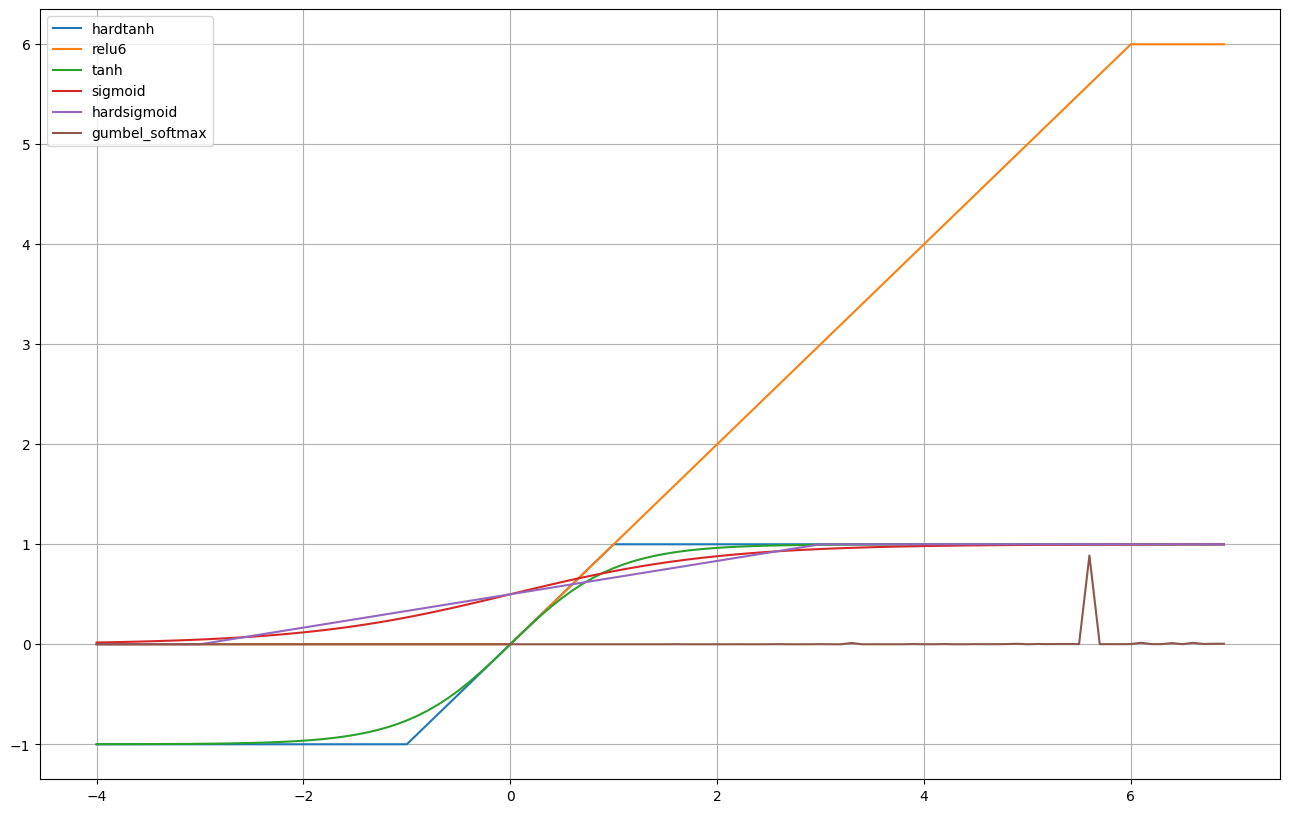

In [100]:
x = torch.arange(-4,7,0.1)

fig, ax = plt.subplots(figsize=(16, 10))

ax.plot(x,Fun.hardtanh(x), label='hardtanh')
ax.plot(x,Fun.relu6(x), label='relu6')
#ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
#ax.plot(x,Fun.hardshrink(x), label='hardshrink')
#ax.plot(x,Fun.tanhshrink(x), label='tanhshrink')
#ax.plot(x,Fun.softshrink(x), label='softshrink')
#ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
ax.plot(x,Fun.tanh(x), label='tanh')
ax.plot(x,Fun.sigmoid(x), label='sigmoid')
ax.plot(x,Fun.hardsigmoid(x), label='hardsigmoid')
ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
ax.legend()
ax.grid()
plt.show()

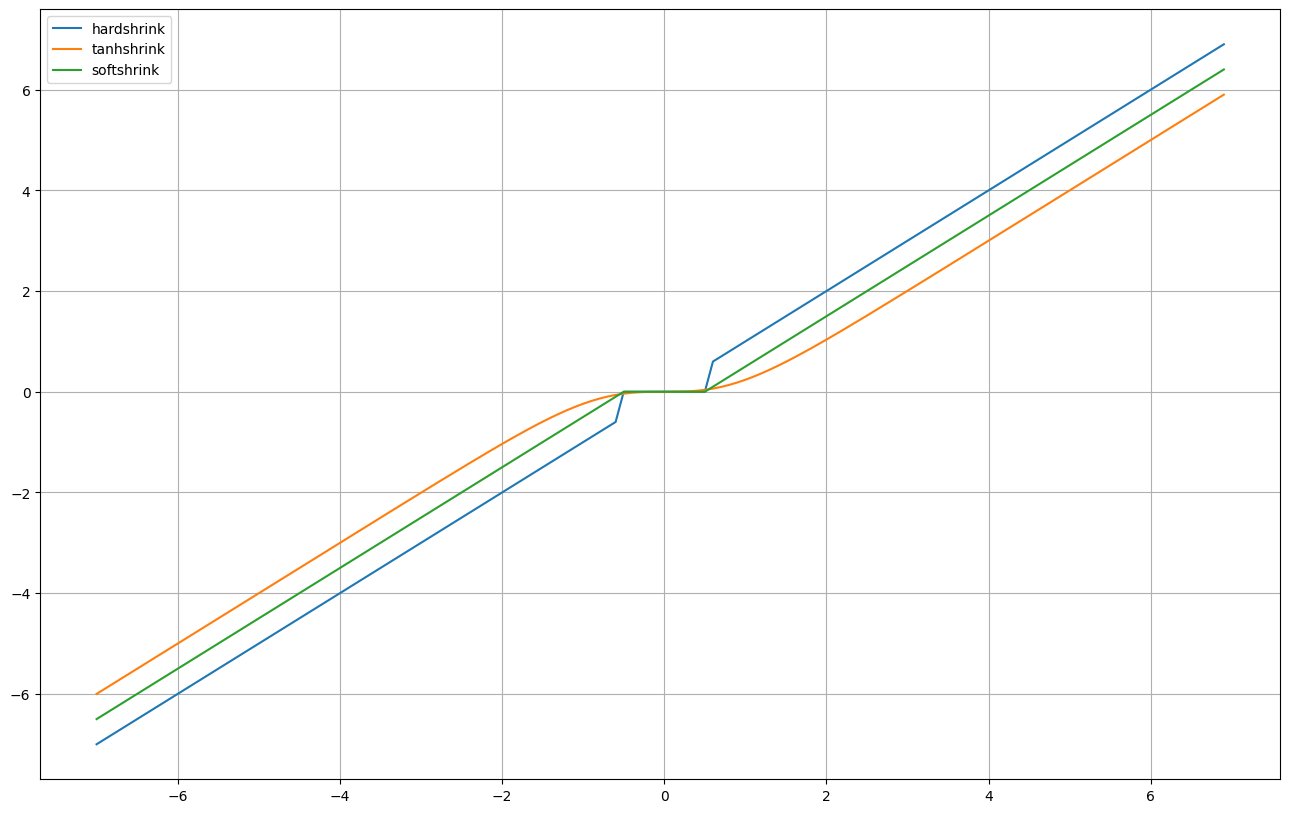

In [101]:
x = torch.arange(-7,7,0.1)

fig, ax = plt.subplots(figsize=(16, 10))

#ax.plot(x,Fun.logsigmoid(x), label='logsigmoid')
ax.plot(x,Fun.hardshrink(x), label='hardshrink')
ax.plot(x,Fun.tanhshrink(x), label='tanhshrink')
ax.plot(x,Fun.softshrink(x), label='softshrink')
#ax.plot(x,Fun.gumbel_softmax(x), label='gumbel_softmax')
ax.legend()
ax.grid()
plt.show()

# backward grad

In [102]:
x = torch.tensor([1.],requires_grad = True)
y = torch.tensor([2.],requires_grad = True)
z = torch.tensor([3.],requires_grad = True)

f = (x+y)*(y-z)
f

tensor([-3.], grad_fn=<MulBackward0>)

In [103]:
f.backward()
x.grad, y.grad, z.grad

(tensor([-1.]), tensor([2.]), tensor([-3.]))

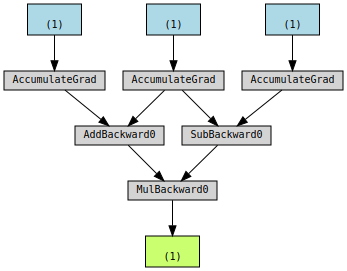

In [104]:
from torchviz import make_dot
make_dot(f)

# Пример задачи регрессии 3 параметра

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import torch

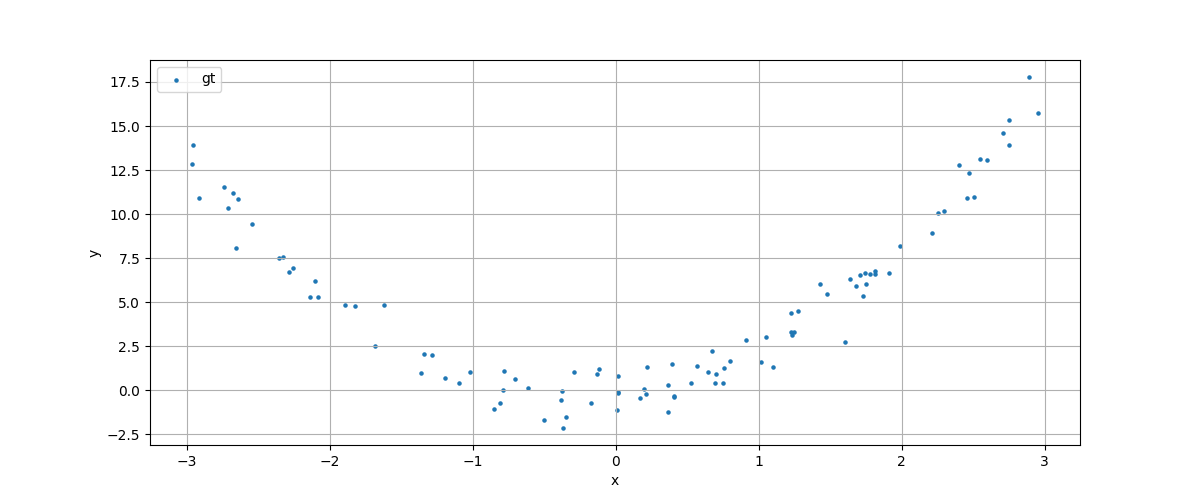

In [96]:
np.random.seed(1234)
_a = np.random.uniform(1, 5)
_b = np.random.uniform(-3, 3)
_c = np.random.uniform(-3, 3)

num_samples = 100

xs = np.random.uniform(-3, 3, size=num_samples)
ys_clean = _a * xs ** 2 + _b * xs + _c
ys_noise = np.random.normal(0, 1, size=len(ys_clean))
ys = ys_clean + ys_noise

plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5)
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)

In [97]:
def model(x, a, b, c):
    return a * x ** 2 + b * x + c

In [98]:
device = torch.device("cuda")
#device = torch.device("cpu")

In [99]:
# YOUR CODE HERE
xs_device = torch.tensor(xs, device=device, requires_grad=False)
ys_device = torch.tensor(ys, device=device, requires_grad=False)
# END OF YOUR CODE

In [100]:
# YOUR CODE HERE
a = torch.randn(1, device=device, requires_grad=True)
b = torch.randn(1, device=device, requires_grad=True)
c = torch.randn(1, device=device, requires_grad=True)
# END OF YOUR CODE

In [103]:
num_epochs = 300
lr = 1e-4
indices = np.arange(len(xs))

loss_list, ys_pred_per_epoch = [], []


for epoch in trange(num_epochs):
    np.random.shuffle(indices)

    mean_loss = 0.
    for i in indices:
        # YOUR CODE HERE
        x      = xs_device[i]
        y_true = ys_device[i]
        y_pred = model(x,a,b,c)
        loss = (y_true - y_pred)**2
        loss.backward()
        # END OF YOUR CODE
        
        with torch.no_grad():
            #a.data -= lr * a.grad.data
            #b.data -= lr * b.grad.data
            #c.data -= lr * c.grad.data
            a -= lr * a.grad
            b -= lr * b.grad
            c -= lr * c.grad
            a.grad.zero_()
            b.grad.zero_()
            c.grad.zero_()
            
        mean_loss += loss.item()
		
        
    loss_list.append(mean_loss/len(xs))


  0%|          | 0/300 [00:00<?, ?it/s]

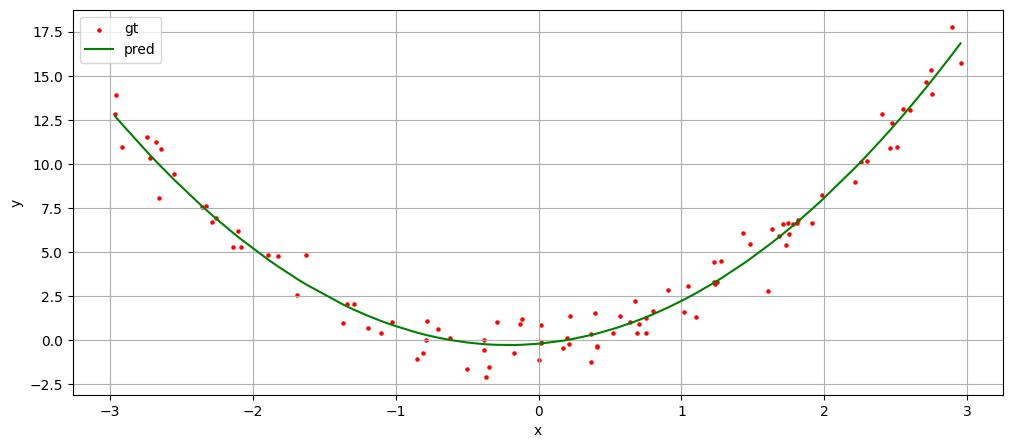

In [20]:
plt.figure(figsize=(12, 5))
plt.scatter(xs, ys, label="gt", s=5, c="r")

xs_sorted = np.sort(xs)
with torch.no_grad():
	ys_pred = model(xs_sorted, a.item(), b.item(), c.item())

plt.plot(xs_sorted, ys_pred, label="pred", c="g")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

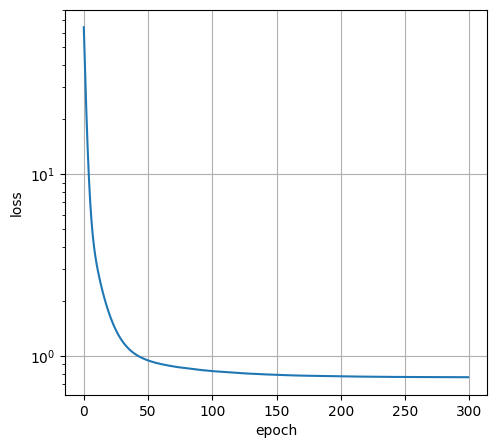

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.grid(True)
plt.yscale("log")

plt.show()